#  THis is the new version of the 

In [3]:
# THIS IS THE FIRST WORKING VERSION WHERE YOU ARE ALSO ABLE TO HAVE REAL REWARDS: 
#PROBLEMS:

# 2. the path is not nicely made
# 3 the aspen doc breaks every once in while
# 4 the agent makes many many actions which dont exist..
# 5 make a logging system test timing.




#import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
import time 

#from gym import Env
#from gym.spaces import Discrete, Box
#import random
#from keras.models import Sequential
#from keras.layers import Dense,Flatten
#from keras.optimizers import Adam
#from rl.agents.dqn import DQNAgent
#from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
#from rl.memory import SequentialMemory


def DCoperationcost(N, R, totflow):
    # N = number of stages
    # R = reflux ratio
    # totflow is total flowrate into DC column in kmol/h
    # see operational cost paper (Massimiliano Erricoa) for breakdown of
    if totflow ==0: 
        stable_env.TotalflowerrorcounterGlobal = stable_env.TotalflowerrorcounterGlobal +1
        print(f' \n \n \n PROBLEM: the total flow is zero.. with Bcounter being: {stable_env.Bcounter} \n \n \n ')
    C = 296.1  # $/m2yr
    Cdash = 17.76  # $/m2yr
    Cddash = 20.61 * 10 ** -3  # $/kmol
    Y = 8000  # h/yr
    E = 90  # % (efficiency assumed)
    G = 219.71  # kmol/hm2
    Gdash = 0.49  # kmol/hm2
    CEPCI2009 = 521.9
    CEPCI2019 = 613.16
    #ZAR = 15.23  # rands per dollar for 01/10/2019

    TAC = (C / (E * Y * G) * N * (1 + R) + Cdash / (Y * Gdash) * (1 + R) + Cddash * (1 + R)) * CEPCI2019 / CEPCI2009
    #TAC = TAC * ZAR  # TAC in rands
    #This is just in case the value is zero...

    TAC = TAC * totflow
    
    return TAC



def columnsize(N, Temp, P, totflow):    # # C bar kmol/sec
    #V=nRT/P
    totflow = (totflow*1000)/3600 #now its mol/sec
    Temp = Temp+273 #from C to K
    Rgas = 8.31445
    P = P*100000 #from bar to Pascal
    volumetric_flow=(totflow*Temp*Rgas)/P #should be m3/sec
    
    # size in feet unless stated otherwise
    # heuristics taken from Ludwig Rules of Thumb

    # NB UNIT CONVERSIONS

    # height
    space = (20 / 12 + 2) / 2  # tray spacing
    trayheight = (N - 1) * space  # height due to tray spacing
    vapallowance = 4  # ft
    liqallowance = 6  # ft
    L = trayheight + vapallowance + liqallowance

    # diameter
    # classed according to heuristic ranges in order to maintain satisfactory diameters
    n_intervals = 10
    interval = np.linspace(27, 170, n_intervals-1)
    interval = list(interval)

    velocity = 0.6  # m/s using Ludwig

    Area = volumetric_flow/velocity
    Di = np.sqrt(Area*4/np.pi)
    Di *= 3.28
    #print(f'for Di needed: area{Area},voluflow{volumetric_flow},totflow{totflow},T{Temp},P{P}')

    """
    LDratio = [1 / 9, 1 / 10, 1 / 11, 1 / 12, 1 / 13, 1 / 14, 1 / 15, 1 / 16, 1 / 17]
    for i in range(n_intervals-2):
        maximum = interval[i + 1]
        minimum = interval[i]
        if L > minimum and L < maximum:
            Di = LDratio[i] * L
            break
    if L < interval[0]:
        Di = LDratio[0] * L
    if L > interval[-1]:
        Di = LDratio[-1] * L
    if N < 11:
        print("Too few stages- resulting column height too low")
    """

    return L, Di





def expensiveDC(Di, L, P, T, N):    # ft ft bar C 

    # VESSEL COSTING
    # Di: feet
    # L: feet
    Po = P*100  #from bar to kpa
    # Po: kpa
    # To: deg c

    To = (T * 9 / 5) + 32  # convert to Celcius to farenheit
    Po = (Po - 101.325) * 0.145038  # kPa to Psig
    # calculating operational pressure
    if Po < 10:  # all pressures in psig
        Pd = 10
    elif Po < 1000:
        Pd = math.exp(0.60608 + 0.91615 * (math.log(Po)) + 0.0015655 * (math.log(Po)) ** 2)
    else:
        Pd = 1.1 * Po
    #print(Pd)

    # calculating S
    Td = To + 50  # degrees F
    interval = np.linspace(650, 900, 6)
    interval = list(interval)
    interval.insert(0, -20)
    Sreturn = [15000, 15000, 15000, 14750, 14200, 13100]
    for i in range(6):
        maximum = interval[i + 1]
        minimum = interval[i]

        if Td > minimum and Td < maximum:
            S = Sreturn[i]
            break

    if Td > interval[-1]:
        S = Sreturn[-1]
        print("Smax")

    if Td < interval[0]:
        S = Sreturn[0]
        print("Smin")
    S = Sreturn[0]


    # calculating E
    E = 0.85  # NB can change dependent on tp
    #print(f'for tp needed: di:{Di},pd{Pd},S{S},E{E},')
    # calculating vessel wall thickness (tp)
    tp = (Pd * Di * 12) / (2 * S * E - 1.2 * Pd)  # converts Di to inches
    #print(tp)

    #print(f'for W needed: Di{Di},tp{tp},L{L},')
    # weight of vessel and heads
    W = math.pi * (Di * 12 + tp) * (L + 0.8 * Di) * 12 * 0.284  # assumes no wind, earthquakes or corrosion, else tp changes
    #print(W)  # pounds
    #print(f'HEy the W is {W}')
    # calculating Cv, Cpl and Cp
    # assumes carbon steel
    CEPCI2003 = 394
    CEPCI2019 = 613.16
    Fm = 1  # carbon steel, can change
    #ZAR = 15.23  # rands per dollar for 01/10/2019
    if W ==0: W= 5      #This just makes it run if there is no actual flow
    Cv2003 = math.exp(7.0374 + 0.18255 * (math.log(W)) + 0.02297 * (math.log(W)) ** 2)
    Cv = Cv2003 * CEPCI2019 / CEPCI2003

    Cpl2003 = 237.1 * Di ** 0.63316 * L ** 0.80161
    Cpl = Cpl2003 * CEPCI2003 / CEPCI2019

    Cp = Fm * Cv + Cpl  # USD
    #Cp = Cp * ZAR
    #print(Cp)

    # calculating tray cost
    # assumes carbon steel sieve trays - else see Seader pg. 532
    Fmt = 1  # material factor for carbon steel
    Ftt = 1  # tray factor for sieve trays
    if N >= 20:
        Fnt = 1
    else:
        Fnt = 2.25 / (1.0414 ** N)

    CBT = 369 * math.exp(0.1739 * Di)
    Ctray2003 = N * Fmt * Ftt * Fnt * CBT
    Ctray = Ctray2003 * CEPCI2019 / CEPCI2003  # USD
    #Ctray = Ctray * ZAR

    # calculating total capital cost
    Ctot = Cp + Ctray
    if W == 0: Ctot = 0
    """
    # throwing error if operating outside of cost correlation limits
    if W < 4200:
        raise ValueError("Vessel weight is too low")
    elif W > 1000000:
        raise ValueError("Vessel weight is too high")
    elif Di < 3:
        raise ValueError("Vessel internal diameter is too low")
    elif Di > 17:
        raise ValueError("Vessel internal diameter is too high")
    elif L < 27:
        raise ValueError("Vessel height is too low")
    elif L > 170:
        raise ValueError("Vessel height is too large")
    elif Td < -20:
        raise ValueError("Vessel design temp is too low")
    elif Td > 900:
        raise ValueError("Vessel design temp is too high")
    else:
        return Ctot
    """

    # throwing error if operating outside of cost correlation limits
    """
    if W < 4200:
        print("Vessel weight is too low")
    elif W > 1000000:
        print("Vessel weight is too high")
    elif Di < 3:
        print("Vessel internal diameter is too low")
    elif Di > 17:
        print("Vessel internal diameter is too high")
    elif L < 27:
        print("Vessel height is too low")
    elif L > 170:
        print("Vessel height is too large")
    elif Td < -20:
        print("Vessel design temp is too low")
    elif Td > 900:
        print("Vessel design temp is too high")
    """
    return Ctot










bla = 1
if bla == 1:
    if bla == 1:

        import xlwings as xw
        wb = xw.Book(r'C:\Users\s2191105\Desktop\DATA from the actual PC\test1.xlsm')

        import random

        path = r'C:\Users\s2191105\Desktop\DATA from the actual PC'      #Folder where you place all our stuff
        book = 'test1.xlsm'     # Name of the excel document
        module = 'Modul1'     #VBA module in the excel dokument 
        wb = xw.Book(r'C:\Users\s2191105\Desktop\DATA from the actual PC\test1.xlsm')
        
        
        
        import os
        from win32com import client
        EXCEL_CLS_NAME = "Excel.Application"
        class XlMacro:
            def __init__(self, path, book, module, name, *args):
                self._path = path  # path containing workbook
                self._book = book  # workbook name like Book1.xlsm
                self._module = module  # module name, e.g., Module1
                self._name = name  # procedure or function name
                self._params = args  # argument(s)
                self._wb = None
            @property
            def workbook(self):
                return self._wb
            @property
            def wb_path(self):
                return os.path.join(self._path, self._book)
            @property
            def name(self):
                return f'{self._book}!{self._module}.{self._name}'
            @property
            def params(self):
                return self._params
            def get_workbook(self):
                wb_name = os.path.basename(self.wb_path)
                try:
                    xl = client.GetActiveObject(EXCEL_CLS_NAME)
                except:
                    # Excel is not running, so we need to handle it.
                    xl = client.Dispatch(EXCEL_CLS_NAME)
                if wb_name in [wb.Name for wb in xl.Workbooks]:
                    return xl.Workbooks[wb_name]
                else:
                    return xl.Workbooks.Open(self.wb_path)
            def Run(self, *args, **kwargs):
                """ 
                Runs an Excel Macro or evaluates a UDF 
                returns None for macro, or the return value of Function
                NB: there is no error-handling here, but there should be!
                """
                keep_open = kwargs.get('keep_open', True)
                save_changes = kwargs.get('save_changes', False)
                self._wb = self.get_workbook()
                xl_app = self._wb.Application
                xl_app.Visible = True
                ret = None
                if args is None:
                    ret = xl_app.Run(self.name)
                elif not args:
                    # run with some default parameters
                    ret = xl_app.Run(self.name, *self.params)
                else:
                    ret = xl_app.Run(self.name, *args)
                if not keep_open:
                    self.workbook.Close(save_changes)
                    self._wb = None
                    xl_app.Quit()
                return ret
            

    
    
#wb = xw.Book(r'C:\Users\s2191105\Desktop\DATA from the actual PC\test1.xlsm') 
#RemoveErrormessages = wb.macro('RemoveErrormessages')
#RemoveErrormessages()    # This sets the suppressed errrormesssages to true


import os
import win32com.client as win32
from gym import Env, spaces
import numpy as np


class Environment(Env):
    def __init__(self, Bcounter, Feed_temp_init, Feed_pressure_init, Feed_flow_Compound1_init, Feed_flow_Compound2_init, Feed_flow_Compound3_init, Feed_flow_Compound4_init, Feed_flow_Compound5_init, Feed_flow_Compound6_init, COMPOUNDNAME1, COMPOUNDNAME2 , COMPOUNDNAME3, COMPOUNDNAME4, COMPOUNDNAME5, COMPOUNDNAME6, COMPOUNDSinlighttoheavystring, Nmax, Refluxratio, Pressure_condens, Pressure_reboiler, Lightkey_recovery ,Heavykey_recovery, OPT_NTRR, BlockpropertiesErrorWeight, DestillationErrorWeight, LifetimeInYears, ValueCompound1, ValueCompound2, ValueCompound3, ValueCompound4, ValueCompound5, ValueCompound6, ConcentrationNeededToGetPaidForStream, FeedValue, PunishmentStageNumber,Punishment_for_invalid_action, HardMaxNegReward):
        self.Bcounter = Bcounter
        self.Feed_temp_init = Feed_temp_init
        self.Feed_pressure_init = Feed_pressure_init
        self.Feed_flow_Compound1_init = Feed_flow_Compound1_init
        self.Feed_flow_Compound2_init = Feed_flow_Compound2_init
        self.Feed_flow_Compound3_init = Feed_flow_Compound3_init
        self.Feed_flow_Compound4_init = Feed_flow_Compound4_init
        self.Feed_flow_Compound5_init = Feed_flow_Compound5_init
        self.Feed_flow_Compound6_init = Feed_flow_Compound6_init
        self.COMPOUNDNAME1 = COMPOUNDNAME1
        self.COMPOUNDNAME2 = COMPOUNDNAME2
        self.COMPOUNDNAME3 = COMPOUNDNAME3
        self.COMPOUNDNAME4 = COMPOUNDNAME4
        self.COMPOUNDNAME5 = COMPOUNDNAME5
        self.COMPOUNDNAME6 = COMPOUNDNAME6
        self.COMPOUNDSinlighttoheavystring = COMPOUNDSinlighttoheavystring
        self.Nmax = Nmax
        self.Refluxratio = Refluxratio
        self.Pressure_condens = Pressure_condens
        self.Pressure_reboiler = Pressure_reboiler
        self.Lightkey_recovery = Lightkey_recovery
        self.Heavykey_recovery = Heavykey_recovery
        self.OPT_NTRR = OPT_NTRR
#REWARD DATA
 
        self.BlockpropertiesErrorWeight = BlockpropertiesErrorWeight #in $ perError
        self.DestillationErrorWeight = DestillationErrorWeight   #in $ perError
        self.LifetimeInYears = LifetimeInYears         #years
        self.ValueCompound1 = ValueCompound1          # $ per kmol/hour
        self.ValueCompound2 = ValueCompound2
        self.ValueCompound3 = ValueCompound3
        self.ValueCompound4 = ValueCompound4
        self.ValueCompound5 = ValueCompound5
        self.ValueCompound6 = ValueCompound6
        self.ValueIfPure = [ValueCompound1, ValueCompound2, ValueCompound3, ValueCompound4, ValueCompound5, ValueCompound6]
        self.ConcentrationNeededToGetPaidForStream = ConcentrationNeededToGetPaidForStream    #needed concentration to get paid
        self.FeedValue = FeedValue       #  $ per kmol/hour
        self.TotalFeedFlow = Feed_flow_Compound1_init + Feed_flow_Compound2_init + Feed_flow_Compound3_init + Feed_flow_Compound4_init + Feed_flow_Compound5_init + Feed_flow_Compound6_init
        self.restarteverything = False
        self.HardMaxNegReward = HardMaxNegReward



        import numpy as np
        import xlwings as xw
        #wb = xw.Book(r'C:\Users\s2191105\Desktop\DATA from the actual PC\test1.xlsm')

        
## THIS IS JUST MAKING IT POSSIBLE TO EXTRACT STUFF FROM VBA TO PYTHON
        
        from win32com import client
        EXCEL_CLS_NAME = "Excel.Application"
        class XlMacro:
            def __init__(self, path, book, module, name, *args):
                self._path = path  # path containing workbook
                self._book = book  # workbook name like Book1.xlsm
                self._module = module  # module name, e.g., Module1
                self._name = name  # procedure or function name
                self._params = args  # argument(s)
                self._wb = None
            @property
            def workbook(self):
                return self._wb
            @property
            def wb_path(self):
                return os.path.join(self._path, self._book)
            @property
            def name(self):
                return f'{self._book}!{self._module}.{self._name}'
            @property
            def params(self):
                return self._params
            def get_workbook(self):
                wb_name = os.path.basename(self.wb_path)
                try:
                    xl = client.GetActiveObject(EXCEL_CLS_NAME)
                except:
                    # Excel is not running, so we need to handle it.
                    xl = client.Dispatch(EXCEL_CLS_NAME)
                if wb_name in [wb.Name for wb in xl.Workbooks]:
                    return xl.Workbooks[wb_name]
                else:
                    return xl.Workbooks.Open(self.wb_path)
            def Run(self, *args, **kwargs):
                """ 
                Runs an Excel Macro or evaluates a UDF 
                returns None for macro, or the return value of Function
                NB: there is no error-handling here, but there should be!
                """
                keep_open = kwargs.get('keep_open', True)
                save_changes = kwargs.get('save_changes', False)
                self._wb = self.get_workbook()
                xl_app = self._wb.Application
                xl_app.Visible = True
                ret = None
                if args is None:
                    ret = xl_app.Run(self.name)
                elif not args:
                    # run with some default parameters
                    ret = xl_app.Run(self.name, *self.params)
                else:
                    ret = xl_app.Run(self.name, *args)
                if not keep_open:
                    self.workbook.Close(save_changes)
                    self._wb = None
                    xl_app.Quit()
                return ret

## THIS IS NO LONGER USER FRIENDLY STUFF NO TOUCHING!!!!!
        self.Errorcounter = 0
        
        self.NumOfPortpossibilities = 0
        self.DoesStreamExistnames = []
        self.DoesStreamExist = []     #No Stream currently exists
        self.IsStreamconnected = []
        self.PossiblePortsforNextdestillation = []
        self.Molflow = np.zeros( (2*Nmax, len(COMPOUNDSinlighttoheavystring)), float)   #define the Table with the flows
        self.Blockproperties = np.zeros( (6, Nmax), float)   #define the Table with the Blockproperites
        self.BlockpropertiesError = np.zeros( ( Nmax), float)
        self.DestillationError = np.zeros( ( Nmax), float)           

# cleaning the Memory of which previous actions where taken
        self.Feedchoices = [ ]
        self.FeedchoicesIndex = []
        self.Lightkeychoices = []
        self.LightkeychoicesIndex = []
        self.RewardmemoryV1 = []
        self.RewardmemoryV2 = []
        self.countingWrongChoices = 0
        self.countingRightChoices = 0
        self.RememberactionFeed = []
        self.RememberactionLightkey = []
        self.RememberRewardV1 = []
        self.RememberRewardV2 = []

        # self.state_for_maximum_rewards = np.zeros( ( self.Nmax), float)
        self.CurrentMaxrewardfromMe  = -1000000
        self.GlobalcounterofError = 0
   #cleaning the entire sheet
        wb = xw.Book(r'C:\Users\s2191105\Desktop\DATA from the actual PC\test1.xlsm') 
        #xREMOVEALLFROMASPEN = wb.macro('REMOVEALLFROMASPEN')
        #xREMOVEALLFROMASPEN()
    #Make action space
        self.action_space = spaces.Discrete((len(self.COMPOUNDSinlighttoheavystring)-1)*self.Nmax*2)
        self.observation_space = spaces.Box(low=0, high=self.TotalFeedFlow, shape=(len(self.Molflow.flatten()),))   #np.shape((self.Molflow)))                           
        self.actions_for_maximum_rewards = []
        #self.state_for_maximum_rewards = []
        self.OperationalcostsForCurrentSequence = 0
        self.molarflowofeachcompoundIncurrentblock = []
        self.totalmolarflowinCurrentBlock = []
        #self.action = 0
        #self.state = self.Molflow
        self.Outputreruncounter = 0
        self.OutputreruncounterGlobal = 0
        self.TotalflowerrorcounterGlobal = 0
        self.NumberofBlockerrors = []
## Making list of possible connections and initalize it

#DoesStreamExistname = [B1T, B1B, B2T, B2B, B3T, B3B, B4T, B4B]
#DoesStreamExist = [0 0 0 0 0 0 0 0 ]
#IsStreamconnected = [0 0 0 0 0 0 0 0 ]
                                            
        for q in range(1,(2*self.Nmax+1)):    # Make string which has name of streams and Boolian wether it exists
            if q & 1 == 1:
                TorB = "T"
            else:
                TorB = "B"
            Bcounternumber = round(q/2 + 0.001)  #Generate the string names of the different Streams
            string = 'B'+ str(Bcounternumber) + str(TorB)  
            self.DoesStreamExistnames.append(string)
            self.DoesStreamExist.append(0)     #No Stream currently exists
            self.IsStreamconnected.append(0)   #No connection has been made yet (only counting  if input amd Output are connected)    
            self.PossiblePortsforNextdestillation.append(0)  # IF 1 then it can be used
            

        
    def findchoices(self):
## 3.1 CHOICE OF NEXT FEED
    # 3.1.1  Find the Possibilities
        import numpy as np
        
        if self.Bcounter > 0:    # If Bcounter = 1 then it is not necessary
            self.NumOfPortpossibilities = 0    #each time a new block gets added reset and recalculate the possibilites
            for i in range(len(self.DoesStreamExist)):
                if self.DoesStreamExist[i] == 1 and self.IsStreamconnected[i] == 0:   #figure out what Ports streams can be connected to  
                    self.PossiblePortsforNextdestillation[i] = 1
                    self.NumOfPortpossibilities = self.NumOfPortpossibilities +1    # total number of available streams
                else:
                    self.PossiblePortsforNextdestillation[i] = 0    # Mark stream as not usable  
        self.actionstringForFeed = np.ones( (self.NumOfPortpossibilities), float)
        self.actionstringForLightkey = np.ones( (len(self.COMPOUNDSinlighttoheavystring)-1), float)
        print(self.PossiblePortsforNextdestillation)



    def Randomechoice(self):
        # magic AI Stuff happens now.... muhuhuuuuhhu, booom, chakalaka
        import random
    # 4.1 Choiceofnextfeed    
        if self.Bcounter == 1:
            self.Nextfeedname = "Initial Feed"
            self.choiceofstreamnumber = None
        else:
            self.choiceofstreamnumber = random.randint(0, 2*self.Nmax-1) #number of stream which was chosen
            while self.PossiblePortsforNextdestillation[self.choiceofstreamnumber] == 0:   # will not run as long choice is not possible
                self.choiceofstreamnumber = random.randint(0, 2*Nmax-1)
            self.Nextfeedname = self.DoesStreamExistnames[self.choiceofstreamnumber]
    
    # 4.2 Choice of lightkey
        self.lightnumber = random.randint(0,len(self.COMPOUNDSinlighttoheavystring)-2)
        self.Lightkey_component = self.COMPOUNDSinlighttoheavystring[self.lightnumber]
        self.Heavykey_component = self.COMPOUNDSinlighttoheavystring[self.lightnumber + 1]
    

    #4.3. Choice to go HOme
# just go home and stop doing stuff. 

        #done = True

    def InputChoice(self):

        #action goes from zero to 2Nmax*(numberofcompounds -1) - 1
        if self.Bcounter == 1:
            self.Nextfeedname = "Initial Feed"
            self.choiceofstreamnumber = None
            self.actionValidBecauseStreamAvailable = True
        else:  #for all other cases except Bcounter = 1
            Streamchoice = self.action % (2*Nmax)   #the first one is a zero
            self.Nextfeedname = self.DoesStreamExistnames[Streamchoice]       #In this case this stream is the next 
            self.choiceofstreamnumber = Streamchoice
    ## NOW I NEED TO CHECK IF THE ACTION IS VALID....
            if self.PossiblePortsforNextdestillation[Streamchoice] == 1:
                self.actionValidBecauseStreamAvailable = True
            else:
                self.actionValidBecauseStreamAvailable = False   

        lightkeychoice = self.action // (2*self.Nmax)   #first one is a zero
        self.Lightkey_component = self.COMPOUNDSinlighttoheavystring[lightkeychoice]
        self.Heavykey_component = self.COMPOUNDSinlighttoheavystring[lightkeychoice + 1]


       
        
        
    def makeProcessandRun(self):
        import xlwings as xw
        wb = xw.Book(r'C:\Users\s2191105\Desktop\DATA from the actual PC\test1.xlsm') 
        ## Create Destillation column in Aspen
        add_DSTWU = wb.macro('add_DSTWU')
        add_DSTWU(self.Bcounter) # B_ without any data

        if self.Bcounter >1:   #the first one cant be seen as "taken" since its not in the index list 
            self.IsStreamconnected[self.choiceofstreamnumber] = 1      # Take Choice and note it as "taken"

# Create STREAM B_T, B_B and also if Bcounter=1 then Feed(creat+connect) but thats coded in VBAexcel 
        add_streams = wb.macro('add_streams')
        add_streams(self.Bcounter, self.Feed_temp_init, self.Feed_pressure_init, self.Feed_flow_Compound1_init, self.Feed_flow_Compound2_init, self.Feed_flow_Compound3_init, self.Feed_flow_Compound4_init, self.Feed_flow_Compound5_init, self.Feed_flow_Compound6_init, self.COMPOUNDNAME1, self.COMPOUNDNAME2, self.COMPOUNDNAME3, self.COMPOUNDNAME4, self.COMPOUNDNAME5, self.COMPOUNDNAME6)

# Note the Streams existance
        self.DoesStreamExist[self.Bcounter*2 -2] = 1   #saves the creation of B_T
        self.DoesStreamExist[self.Bcounter*2-1] = 1   #saves the creation of B_B
        
# Connect STREAM B_T, B_B     
        connect_streams = wb.macro('connect_streams')
        connect_streams(self.Bcounter, self.Nextfeedname)

# Destill propertiesd           
        Destillationinput_RUN = wb.macro('Destillationinput_RUN')
        Destillationinput_RUN(self.Bcounter, self.Refluxratio, self.Pressure_condens, self.Pressure_reboiler, self.Lightkey_component, self.Heavykey_component, self.Lightkey_recovery, self.Heavykey_recovery, self.OPT_NTRR)
        #CheckforErrorInput = XlMacro(path , book, module, 'CheckforErrorInput')
        #self.CheckforErrorInput =  CheckforErrorInput.Run()

        
     
        
    def GetOutputs(self):
    # Destillation properties
        listoffunctions = ['GetDistil_Temp', 'GetBottom_Temp', 'GetREB_Duty', 'GetCond_Duty', 'GetAct_Stages', 'GetAct_Reflux']  
#GO through all Block propertie outputs
        for i in range(0, len(listoffunctions)):    
            functionqq = listoffunctions[i]
            f = XlMacro(path , book, module, functionqq )
            Blockdata = f.Run(self.Bcounter)
            #print(f'The {listoffunctions[i]} is {Blockdata} for B{self.Bcounter}')
            
            if Blockdata == 123456789:   #This means that the extraction is invalid...
                Blockdata = 0
                print(f'FUCK FUCK FUCK FUCK... the extraction of the {functionqq} in B{self.Bcounter} didnt work.. I had to set it to zero')
            #If there doesnt seem to be a problem save it in the matrix
            self.Blockproperties[self.Bcounter-1][i] = Blockdata    # place data into a table
    #now check for errors
            #if self.CheckforErrorInput == None:
                  #Check if the Input worked and remember if it didnt + where 
                #self.Errorcounter = self.Errorcounter +1
                #self.BlockpropertiesError[self.Bcounter] = 1
                #print(f'The Blockproperties have a error: {self.BlockpropertiesError}')
        
        #Get Stream properties
        Compoundcounter = 0
        StreamcounterT = 2*self.Bcounter - 2   #Stream index finding with the Bcounter known
        StreamcounterB = 2*self.Bcounter - 1
        StreamnamesT = f'B{self.Bcounter}T'   #And its string version
        StreamnamesB = f'B{self.Bcounter}B'

# extract data and put it in nice Matrix
        self.molarflowofeachcompoundIncurrentblock = []
        for Compoundnames in self.COMPOUNDSinlighttoheavystring:
            f = XlMacro(path , book, module, 'GetMolflow' )
            self.Molflow[StreamcounterT][Compoundcounter] = f.Run(StreamnamesT, Compoundnames)
            self.Molflow[StreamcounterB][Compoundcounter] = f.Run(StreamnamesB, Compoundnames)
            if self.Molflow[StreamcounterT][Compoundcounter] == 123 or self.Molflow[StreamcounterB][Compoundcounter] == 123:
                print(' \n \n something crashed. MOLFLOW DIDNT WORK \n \n ')
                print(f'before killing it we will now test if the molflow extraction code works... the current values are: {self.Molflow[StreamcounterT][Compoundcounter]} and {self.Molflow[StreamcounterB][Compoundcounter]} if its 123 this means VBA gave a error')
                print(f'the Streamname and Compoundname is: {StreamnamesT} {StreamnamesB} for {Compoundnames}')
                
                testiffileisavailable = 123
                while testiffileisavailable == 123:
                    #time.sleep(10)
                    RunEngine = XlMacro(path , book, module, 'RunEngine')
                    RunEngine = RunEngine.Run()
                    print('run engine and see if you can get the molflow to get molflow')
                    testiffileisavailable =XlMacro(path , book, module, 'GetMolflow')
                    testiffileisavailable = testiffileisavailable.Run('FEED', 'ETHAN-01')
                    print(f'test gave back {testiffileisavailable} this should be 3 and NOT 123 ')
                    #time.sleep(10)
                    self.Outputreruncounter =self.Outputreruncounter+1
                    if self.Outputreruncounter >= 4:
                        print(f'OK now we are seriously fucked.... I will now 1)Kill Aspen 2)sleep for 2min 3)Reopen Aspen 4)RunEngine 5) test Molflow 6) If failed:Set to zero')
                        #kill all the aspen programs
                        dead = os.system("TASKKILL /F /IM Aspenplus.exe")
                        print(f'killed aspen: dead = {dead}')
                        time.sleep(120)
                        #reopen aspen
                        print('not opening aspen to see if that would change something')
                        #revive = os.startfile(r"C:\Users\s2191105\Desktop\DATA from the actual PC\Aspenfresh2.bkp")
                        
                        RunEngine = XlMacro(path , book, module, 'RunEngine')
                        RunEngine = RunEngine.Run()
                        time.sleep(120)
                        print('engine ran')
                        testiffileisavailable =XlMacro(path , book, module, 'GetMolflow')
                        testiffileisavailable = testiffileisavailable.Run('FEED', 'ETHAN-01')
                        f = XlMacro(path , book, module, 'GetMolflow' )
                        self.Molflow[StreamcounterT][Compoundcounter] = f.Run(StreamnamesT, Compoundnames)
                        self.Molflow[StreamcounterB][Compoundcounter] = f.Run(StreamnamesB, Compoundnames)
                        print(f'test gave back {testiffileisavailable} and the actual MOLFLOW values are{self.Molflow[StreamcounterT][Compoundcounter]} and {self.Molflow[StreamcounterB][Compoundcounter]}')
                        if self.Molflow[StreamcounterT][Compoundcounter] ==123 or self.Molflow[StreamcounterB][Compoundcounter] == 123:
                            print('\n \n \n \n \n \n \n \n OK MAJOR MAJOR MAJOR FUCK UP!!!!!! WE KILLED IT, DID THE JESUS MOVE.... STILL BROKEN... \n \n \n \n \n \n \n \n ')
                            print('I will now just set the value to 0.000001')
                            self.Molflow[StreamcounterT][Compoundcounter] =0.000001
                            self.Molflow[StreamcounterB][Compoundcounter]= 0.000001
                        self.Outputreruncounter =0
                print(f'The Aspen is open now. this is the Molflow in Feed: {testiffileisavailable}')
                #rerun the simulation
                

                #Get the molflow back which previously didnt work
                f = XlMacro(path , book, module, 'GetMolflow' )
                self.Molflow[StreamcounterT][Compoundcounter] = f.Run(StreamnamesT, Compoundnames)
                self.Molflow[StreamcounterB][Compoundcounter] = f.Run(StreamnamesB, Compoundnames)
                print(f'after trying to fix it the new values are: {self.Molflow[StreamcounterT][Compoundcounter]} and {self.Molflow[StreamcounterB][Compoundcounter]}')

                #os.startfile(r"C:\Users\s2191105\Desktop\DATA from the actual PC\Aspenfresh2.bkp")
                                #There is a stupid error... lets just rerun the input and the engine and see what happens
                #Destillationinput_RUN = wb.macro('Destillationinput_RUN')
                #Destillationinput_RUN(self.Bcounter, self.Refluxratio, self.Pressure_condens, self.Pressure_reboiler, self.Lightkey_component, self.Heavykey_component, self.Lightkey_recovery, self.Heavykey_recovery, self.OPT_NTRR)
                #Now lets rerun it... it might have changed it
                #f = XlMacro(path , book, module, 'GetMolflow' )
                #self.Molflow[StreamcounterT][Compoundcounter] = f.Run(StreamnamesT, Compoundnames)
                #self.Molflow[StreamcounterB][Compoundcounter] = f.Run(StreamnamesB, Compoundnames)
            blablabla = self.Molflow[StreamcounterT][Compoundcounter]
            blublublu = self.Molflow[StreamcounterB][Compoundcounter]
            Compoundcounter +=1
            self.molarflowofeachcompoundIncurrentblock.append(blablabla) # makes a list of the molflow of each compound in the current block and lists them
            self.molarflowofeachcompoundIncurrentblock.append(blublublu)
        self.totalmolarflowinCurrentBlock.append(sum(self.molarflowofeachcompoundIncurrentblock))
        print(f'This is the sum molarflow of the different blocks {sum(self.molarflowofeachcompoundIncurrentblock)}')


        
    def CheckIfValidaction(self):
#Errorchecker
#Error Destillation collumn input error
        CheckforErrorDestill = XlMacro(path , book, module, 'CheckforErrorDestill')
        self.Destillerrorvalue = CheckforErrorDestill.Run(self.Bcounter)
        if self.Destillerrorvalue == 0:
            self.Errorcounter = self.Errorcounter + 0    #No error
        elif self.Destillerrorvalue == "None": 
            self.Errorcounter = self.Errorcounter +1    #counting errors in the code
        elif self.Destillerrorvalue == 1: 
            self.Errorcounter = self.Errorcounter +1    #counting errors in the code
            self.DestillationError[self.Bcounter-1] = 1

#Check how many errors happend in this episode
        if self.Errorcounter == 0:
            #print('     Episode was sucessful without error')
            self.actionValidity = True
        else:
            #print('     Episode was ended with ' + str(self.Errorcounter)  + ' Errors')
            self.actionValidity = False
            
        #print('')

        
        
    def GetReward(self):
        #initalization
        self.StreamvalueV1 = np.zeros( (2*self.Nmax), float)
        self.StreamvalueV2 = np.zeros( (2*self.Nmax), float)
        self.Molfrac = np.zeros( (2*self.Nmax, len(self.COMPOUNDSinlighttoheavystring)), float)
        self.ValuePerFlowV1 = np.zeros( (2*self.Nmax, len(self.COMPOUNDSinlighttoheavystring)), float)
        self.ValuePerFlowV2 = np.zeros( (2*self.Nmax, len(self.COMPOUNDSinlighttoheavystring)), float)
#Need to be made zero after each run...
        self.Punishment =0
        self.MonetaryGainV1 = 0
        self.MonetaryGainV2 = 0
        self.MonetaryLoss = 0
        self.TOTALREWARDVersion1 = 0
        self.TOTALREWARDVersion2 = 0
        self.CapitalCostNeeded = 0
        self.TotalOperationCost = 0
        self.Ctot = 0


## MONEY GAINED VIA SEPARATION

        #VERSION 1: ValuePerFlow = ValueIfPure * MolFrac   #If you have 99% then you get 99% of value... so 1kg of 50/50 A,B is worth: 0.5*0.5*AValuePerKg + 0.5*0.5*BValuePerKg
#TotalValueOfStream = AmountofA*FractionofA*ValueofPureA
        for Streamnumber in range(0,self.Nmax*2):
            for Compoundnumber in range(0,len(self.COMPOUNDSinlighttoheavystring)):
                if (sum(self.Molflow[:][Streamnumber])) == 0:
                    self.Molfrac[Streamnumber][Compoundnumber] = 0
                else:
                    self.Molfrac[Streamnumber][Compoundnumber] = ((self.Molflow[Streamnumber][Compoundnumber]))/(sum(self.Molflow[:][Streamnumber]))
                
                self.ValuePerFlowV1[Streamnumber][Compoundnumber] = self.ValueIfPure[Compoundnumber] * self.Molfrac[Streamnumber][Compoundnumber]
                self.StreamvalueV1[Streamnumber] = self.StreamvalueV1[Streamnumber] + self.Molflow[Streamnumber][Compoundnumber] * self.ValuePerFlowV1[Streamnumber][Compoundnumber]
        #print(f'VERSION 1: Molfrac is: \n {self.Molfrac}')            
        #print(f'VERSION 1: ValuePerFlow aka Value concentration = {self.ValuePerFlowV1}')
        #print(f'VERSION 1: Streamvalue is {self.StreamvalueV1}')

    
        #VERSION 2: if MolFrac < WantedPurity: ValuePerFlow = ValueIfPure
        for Streamnumber in range(0,Nmax*2):
            for Compoundnumber in range(0,len(COMPOUNDSinlighttoheavystring)):
                if (sum(self.Molflow[:][Streamnumber])) == 0:
                    self.Molfrac[Streamnumber][Compoundnumber]= 0
                else: 
                    self.Molfrac[Streamnumber][Compoundnumber] = ((self.Molflow[Streamnumber][Compoundnumber]))/(sum(self.Molflow[:][Streamnumber]))
                
                if self.Molfrac[Streamnumber][Compoundnumber]>= self.ConcentrationNeededToGetPaidForStream:
                    self.ValuePerFlowV2[Streamnumber][Compoundnumber] = self.ValueIfPure[Compoundnumber]
                else:
                    self.ValuePerFlowV2[Streamnumber][Compoundnumber] = 0
                self.StreamvalueV2[Streamnumber] = self.StreamvalueV2[Streamnumber] + self.Molflow[Streamnumber][Compoundnumber] * self.ValuePerFlowV2[Streamnumber][Compoundnumber]
        #print(f'VERSION 2: Molfrac is: \n {self.Molfrac}')            
        #print(f'VERSION 2: ValuePerFlow aka Value concentration = {self.ValuePerFlowV2}')
        #print(f'VERSION 2: Streamvalue is {self.StreamvalueV2}')        
        
#Find the ones which are outlets and get the value for those aka MonetaryGain = sum(Streamvalue which are also a OUTPUT)  
        for Streamcounter in range(0,self.Nmax*2):
            if self.PossiblePortsforNextdestillation[Streamcounter] == 1: 
                self.MonetaryGainV1 = self.MonetaryGainV1 + self.StreamvalueV1[Streamcounter]

        for Streamcounter in range(0,self.Nmax*2):
            if self.PossiblePortsforNextdestillation[Streamcounter] == 1:    
                self.MonetaryGainV2 = self.MonetaryGainV2 + self.StreamvalueV2[Streamcounter]      #if stream is currently a outlet then add value
            else:
                self.MonetaryGainV2 = self.MonetaryGainV2 + 0
        
     

        self.MonetaryLoss = self.FeedValue * self.TotalFeedFlow




        
        self.TotalNumStages = 0
        for Bcounterer in range(0, Nmax):
            #Find Number of Stages, Refluxratio and Bottom temp in each one Block
            NumberOfActualStages = self.Blockproperties[Bcounterer][4]    # place data into a table
            self.TotalNumStages = self.TotalNumStages + NumberOfActualStages
            Reluxratio = self.Blockproperties[Bcounterer][5]
            Bottom_Temp =  self.Blockproperties[Bcounterer][1]
            
            #If there is a block error and the value is bad change it to these generic values
            if np.isinf(Reluxratio) or np.isnan(Reluxratio):
                Reluxratio = 4
                self.Errorcounter =self.Errorcounter+ 1
                #print(f'Refluxratio had to be set to 4 since there was no data found')
                self.BlockpropertiesError[self.Bcounter] = 1
            if np.isinf(Bottom_Temp) or np.isnan(Bottom_Temp):
                Bottom_Temp = 50
                self.Errorcounter =self.Errorcounter+ 1
                #print(f'The Bottom temp had to be set to 50 since there was no data found')
                self.BlockpropertiesError[self.Bcounter] = 1
            if np.isinf(NumberOfActualStages) or np.isnan(NumberOfActualStages):
                NumberOfActualStages = PunishmentStageNumber
                #print(f'The punishemnt stage number had to be used since there was no data about it')
                self.BlockpropertiesError[self.Bcounter] = 1
                self.Errorcounter =self.Errorcounter+ 1

           #Calculate the Operational costs, capital costs and sizes
            if (len(self.totalmolarflowinCurrentBlock)-1)>=Bcounterer: #if there is such a block then do the economics + sizing
                totflow = self.totalmolarflowinCurrentBlock[Bcounterer]            
                TAC = DCoperationcost(NumberOfActualStages, Reluxratio, totflow)
                self.OperationalcostsForCurrentSequence = self.OperationalcostsForCurrentSequence + TAC
                L, Di = columnsize(NumberOfActualStages, Bottom_Temp, self.Pressure_condens, totflow)    # # C bar kmol/sec

                Ctot = expensiveDC(Di, L, self.Pressure_condens, Bottom_Temp, NumberOfActualStages)    # ft ft bar C 
          #Add the capitalcosts and operational costs of each block
            self.CapitalCostNeeded  =  self.CapitalCostNeeded + Ctot
            self.TotalOperationCost = TAC + self.TotalOperationCost
            
## PUNISHMENTS:

# POSSIBILITES:
    #Punish for making error
        #Bad action choice
            #1 chose the heaviest as the light key
            #2 try to chose a stream which was already chosen?
            #3 try to chose

        #Destillation output error
#            BlockpropertiesError[Bcounter] =1   # This is stuff like Cond duty which might be not defined..
        #Simulation error (not enough Trays possible)
#             DestillationError[Bcounter] = 1     # Does simulation run?
            
        self.Punishment = sum(self.BlockpropertiesError)*self.BlockpropertiesErrorWeight + sum(self.DestillationError)*self.DestillationErrorWeight

            
     

    # to turn the Capital costs into running costs it will be assumed that it is paid of over the entire lifetime every single hour
        self.HoursInLifetimeOfPlant = self.LifetimeInYears*8760
        self.MoneyForBankers = self.CapitalCostNeeded/self.HoursInLifetimeOfPlant


        #print(f'Punishment for being a bad boy is around {self.Punishment}')
        #print( f'MONETARY LOSS FROM BUYING THE FEED = {self.MonetaryLoss}')
        #print(f'MonetaryGain V1  = { self.MonetaryGainV1} and for V2 = {self.MonetaryGainV2}')

##ccccccccc           DO NOT DOUBLE COUNT PUNISHMENTS!!!!!!!!!!!!!!!!!!!!!!



### Get the overall final Reward:  (Measured in $ per hour)
        self.TOTALREWARDVersion1 = self.MonetaryGainV1 - self.Punishment - self.MonetaryLoss - self.MoneyForBankers - self.OperationalcostsForCurrentSequence
        self.TOTALREWARDVersion2 = self.MonetaryGainV2 - self.Punishment - self.MonetaryLoss - self.MoneyForBankers - self.OperationalcostsForCurrentSequence

        
        
    def GimmeAllMyPrintOut(self):
        print('\n ***************************** MAKING AND RUNNNING PROCESS ****************************** \n \n')
        #print(f'IsStreamconnected = {Env2.IsStreamconnected} ')
        #print(f'PossiblePortsforNextdestillation = {Env2.PossiblePortsforNextdestillation} ')


## FINDING POSSIBLE CHOICES
        print(f'\n ****************************** FIND ACTIONSPACE after running Bcounter = {self.Bcounter} *****************************')
        print(f'The Possile ports from all streams are: {self.PossiblePortsforNextdestillation}')     
        print(f'actual choices for Feed: {self.actionstringForFeed}')
        print(f'actual choices for Lightkey: {self.actionstringForLightkey}')


## Make Randome Choice
        print('\n ****************************** CHOICE WHICH WAS MADE ******************************')
        print(f'the lightkey is {self.Lightkey_component} and the heavykey is {self.Heavykey_component}')
        #print(f'its numerical string value is: {self.lightnumber}')
        print(f'The Nextfeedname is: {self.Nextfeedname}')
        print(f'its numerical string value is: {self.choiceofstreamnumber}')


## Set the Agents choice as a choice:
#print('\n ****************************** SET AGENT CHOICE ******************************')

# Env2.lightnumber = action1
# Env2.choiceofstreamnumber = action2


## makeProcessandRun
        print('\n ****************************** Made Process + Ran ******************************')
        print(f'After connecting feed IsStreamconnected is: {self.IsStreamconnected}')
        print(f' DoesStreamExist is: {self.DoesStreamExist}')
        #print('   Blockinput Error ' + str(self.CheckforErrorInput))

## Get Outputs
        print('\n ************************ Get Outputs ******************************')
        print(f'The molarflowrate is: \n {self.Molflow}')
        print(f'The Blockproperties are: \n {self.Blockproperties}')

## CHECK for ERROR
        print('\n ************************ CheckIfValid ******************************')
        print(f'The problem in Block is in: {self.BlockpropertiesError}')
        print(f'The problem in Destillation is in: {self.DestillationError}')
        print(f'actionValidity is = {self.actionValidity}')

# GET REWARD
        print('\n ************************ GET REWARD ******************************')

        print(f'VERSION 1: ValuePerFlow aka Value concentration = {self.ValuePerFlowV1}')
        print(f'VERSION 1: Streamvalue is {self.StreamvalueV1}')
        print(f'VERSION 2: ValuePerFlow aka Value concentration = {self.ValuePerFlowV2}')
        print(f'VERSION 2: Streamvalue is {self.StreamvalueV2}')     
        print(f'Punishment for being a bad boy is around {self.Punishment}')
        print( f'MONETARY LOSS FROM BUYING THE FEED = {self.MonetaryLoss}')
        print(f'MonetaryGain V1  = { self.MonetaryGainV1} and for V2 = {self.MonetaryGainV2}')
        print(f'The total Capitalcosts are around {Ctot}')
        print(f'the money for the bankers is: {self.MoneyForBankers} ')
        print(f'TOTALREWARDVersion1 = {self.TOTALREWARDVersion1}')
        print(f'TOTALREWARDVersion2 = {self.TOTALREWARDVersion2}')
        print('\n \n \n')
        print(f'the Operational costs in $/yearis : {TAC}')  #in $/year
        print(f'the length of the column is {L}')
        print(f'the inner diameter is: {Di}')
        print(f'the total capital costs are {Ctot}')  
## REMEMBERED ACTIONS AND REWARDS\

        print(f'For V1 the rewards were = {self.RememberRewardV1}')
        print(f'For V2 the rewards were = {self.RememberRewardV2}')
        print(f'The choices for Feed were: {self.RememberactionFeed}')
        print(f'The choices for Lightkey were: {self.RememberactionLightkey}')
        print(f'The Choice of the actual action: {self.action}  ')
        
        
    def reset(self):
        self.Bcounter = 1
        import numpy as np
        import xlwings as xw
        wb = xw.Book(r'C:\Users\s2191105\Desktop\DATA from the actual PC\test1.xlsm')
## THIS IS JUST MAKING IT POSSIBLE TO EXTRACT STUFF FROM VBA TO PYTHON
        import os
        from win32com import client
        EXCEL_CLS_NAME = "Excel.Application"
        class XlMacro:
            def __init__(self, path, book, module, name, *args):
                self._path = path  # path containing workbook
                self._book = book  # workbook name like Book1.xlsm
                self._module = module  # module name, e.g., Module1
                self._name = name  # procedure or function name
                self._params = args  # argument(s)
                self._wb = None
            @property
            def workbook(self):
                return self._wb
            @property
            def wb_path(self):
                return os.path.join(self._path, self._book)
            @property
            def name(self):
                return f'{self._book}!{self._module}.{self._name}'
            @property
            def params(self):
                return self._params
            def get_workbook(self):
                wb_name = os.path.basename(self.wb_path)
                try:
                    xl = client.GetActiveObject(EXCEL_CLS_NAME)
                except:
                    # Excel is not running, so we need to handle it.
                    xl = client.Dispatch(EXCEL_CLS_NAME)
                if wb_name in [wb.Name for wb in xl.Workbooks]:
                    return xl.Workbooks[wb_name]
                else:
                    return xl.Workbooks.Open(self.wb_path)
            def Run(self, *args, **kwargs):
                """ 
                Runs an Excel Macro or evaluates a UDF 
                returns None for macro, or the return value of Function
                NB: there is no error-handling here, but there should be!
                """
                keep_open = kwargs.get('keep_open', True)
                save_changes = kwargs.get('save_changes', False)
                self._wb = self.get_workbook()
                xl_app = self._wb.Application
                xl_app.Visible = True
                ret = None
                if args is None:
                    ret = xl_app.Run(self.name)
                elif not args:
                    # run with some default parameters
                    ret = xl_app.Run(self.name, *self.params)
                else:
                    ret = xl_app.Run(self.name, *args)
                if not keep_open:
                    self.workbook.Close(save_changes)
                    self._wb = None
                    xl_app.Quit()
                return ret

## THIS IS NO LONGER USER FRIENDLY STUFF NO TOUCHING!!!!!
        self.Errorcounter = 0 
        self.NumOfPortpossibilities = 0
        self.DoesStreamExistnames = []
        self.DoesStreamExist = []     #No Stream currently exists
        self.IsStreamconnected = []
        self.PossiblePortsforNextdestillation = []
        self.Molflow = np.zeros( (2*self.Nmax, len(self.COMPOUNDSinlighttoheavystring)), float)   #define the Table with the flows
        self.Blockproperties = np.zeros( (6, self.Nmax), float)   #define the Table with the Blockproperites
        self.BlockpropertiesError = np.zeros( ( self.Nmax), float)
        self.DestillationError = np.zeros( ( self.Nmax), float)           

# cleaning the Memory of which previous actions where taken
        self.Feedchoices = [ ]
        self.FeedchoicesIndex = []
        self.Lightkeychoices = []
        self.LightkeychoicesIndex = []
        self.RewardmemoryV1 = []
        self.RewardmemoryV2 = []
        
        #self.actions1_for_maximum_rewards = []
        #self.actions2_for_maximum_rewards = []
        #self.state_for_maximum_rewards = []
        #self.CurrentMaxrewardfromMe  = 0
        #self.RememberactionFeed = []
        #self.RememberactionLightkey = []
        #self.RememberRewardV1 = []
        #self.RememberRewardV2 = []
        
   #cleaning the entire sheet
        wb = xw.Book(r'C:\Users\s2191105\Desktop\DATA from the actual PC\test1.xlsm') 
        xREMOVEALLFROMASPEN = wb.macro('REMOVEALLFROMASPEN')
        xREMOVEALLFROMASPEN()
    #Make action space
        self.action_space = spaces.Discrete((len(self.COMPOUNDSinlighttoheavystring)-1)*self.Nmax*2)
        self.observation_space = spaces.Box(low=0, high=self.TotalFeedFlow, shape=(0,len(self.Molflow.flatten())))     #np.shape((self.Molflow)))                          
        self.action = 0
        self.reward = 0
        self.state = np.squeeze(self.Molflow.flatten())
        self.OperationalcostsForCurrentSequence = 0
        self.molarflowofeachcompoundIncurrentblock = []
        self.totalmolarflowinCurrentBlock = []
        self.Outputreruncounter = 0
## Making list of possible connections and initalize it

#DoesStreamExistname = [B1T, B1B, B2T, B2B, B3T, B3B, B4T, B4B]
#DoesStreamExist = [0 0 0 0 0 0 0 0 ]
#IsStreamconnected = [0 0 0 0 0 0 0 0 ]
                                            
        for q in range(1,(2*self.Nmax+1)):    # Make string which has name of streams and Boolian wether it exists
            if q & 1 == 1:
                TorB = "T"
            else:
                TorB = "B"
            Bcounternumber = round(q/2 + 0.001)  #Generate the string names of the different Streams
            string = 'B'+ str(Bcounternumber) + str(TorB)  
            self.DoesStreamExistnames.append(string)
            self.DoesStreamExist.append(0)     #No Stream currently exists
            self.IsStreamconnected.append(0)   #No connection has been made yet (only counting  if input amd Output are connected)    
            self.PossiblePortsforNextdestillation.append(0)  # IF 1 then it can be used
                                            
        return self.state
        
        
        
    def rememberAction(self):
        self.RememberactionFeed.append(self.Nextfeedname)
        self.RememberactionLightkey.append(self.Lightkey_component)
        self.RememberRewardV1.append(self.TOTALREWARDVersion1)
        self.RememberRewardV2.append(self.TOTALREWARDVersion2)
        
    def step(self,action):
        self.action = action
        self.oldstate = self.state
        done = False
        self.InputChoice() #insert action, convert that into internal index version  + check if valid.
        if self.actionValidBecauseStreamAvailable == False:    #this means that the action is not valid. old state is returned, agent needs to try again
            self.state = self.oldstate
            self.countingWrongChoices = self.countingWrongChoices+1
            self.Bcounter = self.Bcounter + 0
            self.reward = self.reward  - Punishment_for_invalid_action
            info = {"sucessful action": "no"}
        elif self.actionValidBecauseStreamAvailable == True:
            self.makeProcessandRun()
            self.GetOutputs()
            self.CheckIfValidaction()
            self.GetReward()
            self.findchoices()
            self.rememberAction()
            self.countingRightChoices = self.countingRightChoices +1
            
            self.reward = self.TOTALREWARDVersion1
            #self.reward = self.TOTALREWARDVersion2
            
            self.Bcounter = self.Bcounter + 1   #increase Bcounter
            self.state = np.squeeze(self.Molflow.flatten())      #define new state
            self.GlobalcounterofError  = self.GlobalcounterofError + self.Errorcounter
            if self.Bcounter == self.Nmax:
                done = True
                if self.CurrentMaxrewardfromMe <= self.reward:
                    self.CurrentMaxrewardfromMe = self.reward
                    for i in range((-Nmax+1),0):
                        self.actions1_for_maximum_rewards.append(self.RememberactionFeed[i])
                        self.actions2_for_maximum_rewards.append(self.RememberactionLightkey[i])
                    self.state_for_maximum_rewards.append(self.state)
                    #print(self.state_for_maximum_rewards)
                self.NumberofBlockerrors.append(sum(self.BlockpropertiesError))
                #print(f' \n the Global number of errors for Blockproperties is {self.NumberofBlockerrors[-1]}')
                #print(f'then Global number fo errors in total is: {self.GlobalcounterofError} only gets reset by initalizing the class')
                
              
            info = {"sucessful action": "yes"}
            #self.GimmeAllMyPrintOut()
            if self.reward <= self.HardMaxNegReward:     #THis means the reward is extremly highly negaitve and we will set it to the maximum
                self.reward = self.HardMaxNegReward
                print('Hey it seems like the reward was too negative... ')
                
        return self.state, self.reward, done, info
    
    
    def render(self):
        pass


    def RestartEverythingNow(self):
        self.restarteverything = True
        #close aspen
        #restart aspen
        #load old model
        #resetaspen aka reset
        #Get out of the stepfunction
        print(' \n \n \n \n \n \n \n \n \n HAD TO RESTART EVERYTHING \n \n \n \n \n \n \n \n \n \n')
    
class StableEnv(Environment):
    def __init__(self, *args, **kwargs):
        super(StableEnv, self).__init__(*args, **kwargs)
        
    def step(self, action):
        state, reward, done, info = super(StableEnv, self).step(action)
        if np.isinf(reward) or np.isnan(reward):
            reward = -1e3
        return state, reward, done, info
    
    def legal_actions(self):
        # ones for legal actions, zeros for illgal actions
        row_width = 6
        mask = np.zeros(self.action_space.n)
        for i in range(0, self.Bcounter):
            slicer_legal = (np.arange(self.action_space.n) % i) == 0
        mask[slicer_legal] = 1
        mask[-1] = 0 # this is pretend so we have one illegal action
        return mask

# The class from 11.06.2021

In [ ]:
path = r'C:\Users\s2191105\Desktop\DATA from the actual PC'      #Folder where you place all our stuff
book = 'test1.xlsm'     # Name of the excel document
module = 'Modul1'     #VBA module in the excel dokument 

f = XlMacro(path , book, module, 'GetDistil_Temp')
Blockdata = f.Run(1)
print(Blockdata)

# NEW WAY TO GET REWARD

In [14]:
Feed_temp_init = 20               #degree C
Feed_pressure_init = 5            # Bar
Feed_flow_Compound1_init = 3      # KiloMOL/Hour
Feed_flow_Compound2_init = 5
Feed_flow_Compound3_init = 12
Feed_flow_Compound4_init = 2
Feed_flow_Compound5_init = 9
Feed_flow_Compound6_init = 7
COMPOUNDNAME1 = "ETHAN-01"
COMPOUNDNAME2 = "PROPY-01"
COMPOUNDNAME3 = "PROPA-01"
COMPOUNDNAME4 = "1-BUT-01"
COMPOUNDNAME5 = "N-BUT-01"
COMPOUNDNAME6 = "N-PEN-01"
COMPOUNDSinlighttoheavystring = ["ETHAN-01", "PROPY-01", "PROPA-01", "1-BUT-01", "N-BUT-01", "N-PEN-01"]
Nmax = 6  #Number of Reactors
Refluxratio = -1.1                    
Pressure_condens = 5                 
Pressure_reboiler = 5        
Lightkey_recovery = 0.95
Heavykey_recovery = 1 - Lightkey_recovery
OPT_NTRR = "RR"       #'Define your selection of reflux and not by the num of stages'




LifetimeInYears = 20         #years
ValueCompound1 = 0.000016 *1000000       # $ per kmol/hour
ValueCompound2 = 0.0000285*1000000
ValueCompound3 = 0.0000454*1000000
ValueCompound4 = 0.0000381*1000000
ValueCompound5 = 0.0000754*1000000
ValueCompound6 = 0.0000576*1000000
ConcentrationNeededToGetPaidForStream = 0.94    #needed concentration to get paid
FeedValue = 0.000001        #  $ per kmol/hour
Bcounter = 1

Date = '14_6'
CloseAspen = True
LoadOldModelplease = False
Loadfilename = 'This_is_just_the_most_recent_file.h5'
LEARNINGRATE = 0.03
NumberOfSteps = 1000
NumberofLoops = 100
Version = 'AAA'       #This represents how many times there was a error and it had to be retrained
PunishmentStageNumber = 150
Punishment_for_invalid_action = 200
HardMaxNegReward = -7000
BlockpropertiesErrorWeight = 1000 #in $ perError
DestillationErrorWeight = 1000   #in $ perError
ConcentrationNeededToGetPaidForStream = 0.90    #needed concentration to get paid
maximumTAC = 2030
RewardVersion = 'V2'

"""
CHANGES TO CLASS TO MAKE IT WORK
    - stop it from cleaning the sheet aka make "REMOVEALLFROMASPEN" a comment
    - make a copy to the aspen in a different folder (just for safety)
    - change the excel name 
    - open aspen file and run simulation
    
    - TRY IT
    ...
    ...
    - if fix bugs by commenting variables which dont exist

"""

list_of_AspenFiles = ['AspennotusingthelastBlockandonlytakinga_uselessoperation___NO_ERROR_V2.bkp', 'ASPENequimolarseparation.bkp', 'ASPENlightkeyfirstseparation.bkp', 'ASPENheavykeyfirstseparation.bkp', 'ASPENlargestcomponentfirst.bkp' ]
#if 1<2:
stable_env = StableEnv(Bcounter, Feed_temp_init, Feed_pressure_init, Feed_flow_Compound1_init, Feed_flow_Compound2_init, Feed_flow_Compound3_init, Feed_flow_Compound4_init, Feed_flow_Compound5_init, Feed_flow_Compound6_init, COMPOUNDNAME1, COMPOUNDNAME2 , COMPOUNDNAME3, COMPOUNDNAME4, COMPOUNDNAME5, COMPOUNDNAME6, COMPOUNDSinlighttoheavystring, Nmax, Refluxratio, Pressure_condens, Pressure_reboiler, Lightkey_recovery ,Heavykey_recovery, OPT_NTRR, BlockpropertiesErrorWeight, DestillationErrorWeight, LifetimeInYears, ValueCompound1, ValueCompound2, ValueCompound3, ValueCompound4, ValueCompound5, ValueCompound6, ConcentrationNeededToGetPaidForStream, FeedValue,PunishmentStageNumber, Punishment_for_invalid_action, HardMaxNegReward) #Initialization of the Simulator 
for i in list_of_AspenFiles:
    
    wb = xw.Book(r'C:\Users\s2191105\Desktop\DATA from the actual PC\test1.xlsm') 
    xchange_Aspen_name = wb.macro('change_Aspen_name')
    xchange_Aspen_name(i)
    #xchange_Aspen_name('ASPENlargestcomponentfirst.bkp')
    
    for stable_env.Bcounter in range(1,Nmax,1):
        stable_env.findchoices()
        stable_env.DoesStreamExist[stable_env.Bcounter*2 -2] = 1   #saves the creation of B_T
        stable_env.DoesStreamExist[stable_env.Bcounter*2-1] = 1   #saves the creation of B_B
        stable_env.GetOutputs()
        stable_env.CheckIfValidaction()
        stable_env.GetReward()
        if RewardVersion == 'V2':
            stable_env.reward = stable_env.TOTALREWARDVersion2
        if RewardVersion == 'V1':
            stable_env.reward = stable_env.TOTALREWARDVersion1
        
        stable_env.state = np.squeeze(stable_env.Molflow.flatten())      #define new state
    print(f'Monetary gain V1 {stable_env.MonetaryGainV1}')
    print(f'Monetary gain V2 {stable_env.MonetaryGainV2}')
    print(f'Punishment {stable_env.Punishment}')
    #print(f' Monetary loss {stable_env.MonetaryLoss}') 
    print(f'Mooney for Bankers {stable_env.MoneyForBankers}')
    print(f'Operational costs: {stable_env.OperationalcostsForCurrentSequence}')
    print(stable_env.Molflow)
    print(f'reward Version 1 in the {i}: {stable_env.TOTALREWARDVersion1}')
    print(f'reward Version 2 in the {i}: {stable_env.TOTALREWARDVersion2}')
    
    stable_env.reset()
#print(f'the reward after completion: {stable_env.reward}')
### ON the 01.06.2021 teh values were:
#lightest key first= -129.21, no error
#heavykey = -43.88, no error
#equimolar = -74.58, no error
#largestcompound = -74.68, no error


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
This is the sum molarflow of the different blocks 38.0000000303608
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
This is the sum molarflow of the different blocks 30.87062124964762
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
This is the sum molarflow of the different blocks 22.299430546310106
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
This is the sum molarflow of the different blocks 3.2579745224927157
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
This is the sum molarflow of the different blocks 0.16260797572315847
Monetary gain V1 2167.084165712852
Monetary gain V2 1047.8893087518002
Punishment 0.0
Mooney for Bankers 3.396003816792059
Operational costs: 20.684738089229565
[[2.99998492e+00 4.99963406e+00 1.19971891e+01 1.97381316e+00
  8.55000000e+00 3.50000000e-01]
 [1.50836668e-05 3.65943004e-04 2.81092269e-03 2.61868410e-02
  4.50000000e-01 6.65000000e+00]
 [2.99998492e+00 4.99963406e+00 1.19971891e+01 1.87512250e+00
  4.27500000e-01 0.00000000e+00]
 [1.44939986e-16 2.4419952

KeyboardInterrupt: 

#  PROGRAM to make a aspen file from actions, find reward, get 5 best action list

In [19]:
##INPUT
## found from short training
#feed_for_max_reward_original= ['Initial Feed', 'B1T', 'B2B', 'B2T', 'B3B', 'Initial Feed', 'B1B', 'B1T', 'B2B', 'B4B', 'Initial Feed', 'B1T', 'B1B', 'B3T', 'B4T', 'Initial Feed', 'B1B', 'B1T', 'B3B', 'B4B', 'Initial Feed', 'B1B', 'B1T', 'B3B', 'B4B', 'Initial Feed', 'B1T', 'B2B', 'B2T', 'B1B', 'Initial Feed', 'B1T', 'B2T', 'B3B', 'B4T', 'Initial Feed', 'B1T', 'B2T', 'B3B', 'B2B', 'Initial Feed', 'B1T', 'B2B', 'B1B', 'B4T', 'Initial Feed', 'B1T', 'B2T', 'B3B', 'B1B', 'Initial Feed', 'B1T', 'B2B', 'B3B', 'B2T', 'Initial Feed', 'B1T', 'B2T', 'B2B', 'B3T', 'Initial Feed', 'B1T', 'B1B', 'B3B', 'B2B', 'Initial Feed', 'B1T', 'B2T', 'B1B', 'B4B', 'Initial Feed', 'B1T', 'B2T', 'B3B', 'B4T', 'Initial Feed', 'B1B', 'B2T', 'B3B', 'B4T', 'Initial Feed', 'B1B', 'B2B', 'B1T', 'B4B', 'Initial Feed', 'B1T', 'B2B', 'B3T', 'B4T', 'Initial Feed', 'B1T', 'B2B', 'B3B', 'B1B', 'Initial Feed', 'B1T', 'B1B', 'B3T', 'B2B', 'Initial Feed', 'B1T', 'B2B', 'B3B', 'B2T', 'Initial Feed', 'B1B', 'B2T', 'B1T', 'B4T', 'Initial Feed', 'B1T', 'B2T', 'B3B', 'B1B', 'Initial Feed', 'B1B', 'B1T', 'B2B', 'B4T', 'Initial Feed', 'B1B', 'B1T', 'B3B', 'B4T', 'Initial Feed', 'B1T', 'B2B', 'B3B', 'B3T', 'Initial Feed', 'B1B', 'B2T', 'B3T', 'B4B', 'Initial Feed', 'B1T', 'B2T', 'B3T', 'B4B', 'Initial Feed', 'B1T', 'B1B', 'B2B', 'B4B', 'Initial Feed', 'B1T', 'B2T', 'B2B', 'B4B', 'Initial Feed', 'B1T', 'B2B', 'B2T', 'B3T', 'Initial Feed', 'B1T', 'B2T', 'B3B', 'B3T']
#lightkey_for_max_reward_original= ['1-BUT-01', 'N-BUT-01', '1-BUT-01', 'N-BUT-01', 'PROPY-01', 'PROPA-01', 'N-BUT-01', '1-BUT-01', 'N-BUT-01', 'PROPA-01', 'ETHAN-01', 'PROPA-01', 'N-BUT-01', 'PROPA-01', 'PROPA-01', 'PROPA-01', 'N-BUT-01', 'PROPA-01', 'N-BUT-01', 'N-BUT-01', 'ETHAN-01', 'PROPY-01', 'PROPA-01', 'ETHAN-01', 'PROPY-01', 'PROPY-01', 'ETHAN-01', 'PROPY-01', '1-BUT-01', '1-BUT-01', 'PROPA-01', 'N-BUT-01', 'PROPA-01', 'PROPY-01', 'N-BUT-01', 'PROPA-01', 'PROPY-01', 'ETHAN-01', 'ETHAN-01', 'PROPA-01', 'PROPA-01', 'N-BUT-01', 'PROPA-01', 'PROPA-01', '1-BUT-01', 'ETHAN-01', 'PROPA-01', 'ETHAN-01', 'ETHAN-01', '1-BUT-01', 'PROPA-01', 'ETHAN-01', 'PROPA-01', 'N-BUT-01', 'N-BUT-01', 'PROPA-01', 'N-BUT-01', 'PROPA-01', 'PROPA-01', 'ETHAN-01', 'PROPY-01', 'ETHAN-01', 'PROPY-01', 'PROPY-01', '1-BUT-01', 'PROPY-01', 'ETHAN-01', 'PROPA-01', 'N-BUT-01', '1-BUT-01', 'N-BUT-01', '1-BUT-01', 'ETHAN-01', 'PROPY-01', 'ETHAN-01', 'PROPA-01', 'PROPA-01', '1-BUT-01', 'N-BUT-01', 'PROPA-01', 'ETHAN-01', 'PROPA-01', 'N-BUT-01', 'ETHAN-01', 'PROPY-01', 'ETHAN-01', 'PROPA-01', '1-BUT-01', 'PROPA-01', 'N-BUT-01', 'PROPA-01', 'PROPA-01', 'PROPA-01', 'N-BUT-01', 'N-BUT-01', '1-BUT-01', 'ETHAN-01', 'N-BUT-01', 'PROPA-01', 'PROPY-01', 'PROPY-01', 'N-BUT-01', 'PROPY-01', 'PROPY-01', 'ETHAN-01', 'N-BUT-01', 'N-BUT-01', 'N-BUT-01', 'PROPA-01', 'PROPY-01', 'PROPA-01', 'PROPA-01', 'PROPA-01', '1-BUT-01', 'N-BUT-01', 'PROPA-01', 'PROPY-01', 'PROPA-01', 'PROPA-01', 'PROPY-01', 'PROPA-01', 'PROPA-01', '1-BUT-01', 'PROPA-01', '1-BUT-01', 'PROPY-01', '1-BUT-01', 'PROPY-01', 'PROPA-01', 'PROPA-01', 'ETHAN-01', 'N-BUT-01', 'ETHAN-01', 'N-BUT-01', '1-BUT-01', 'PROPA-01', 'PROPA-01', 'ETHAN-01', '1-BUT-01', 'ETHAN-01', '1-BUT-01', 'PROPA-01', 'N-BUT-01', 'N-BUT-01', 'PROPA-01', 'N-BUT-01', '1-BUT-01', 'ETHAN-01', 'N-BUT-01', 'PROPY-01', 'N-BUT-01', 'PROPA-01', 'N-BUT-01', 'ETHAN-01', 'PROPA-01', 'PROPA-01', 'ETHAN-01', 'PROPY-01', '1-BUT-01', 'ETHAN-01']
    #This yielded  the max reward of: -38.94774942448791 ['PROPY-01', 'ETHAN-01', 'PROPA-01', 'N-BUT-01', '1-BUT-01'] ['Initial Feed', 'B1T', 'B2T', 'B1B', 'B4B']
    # -42.97795394309483  ['ETHAN-01', 'PROPA-01', 'ETHAN-01', 'ETHAN-01', '1-BUT-01']  ['Initial Feed', 'B1T', 'B2T', 'B3B', 'B1B']
    # -42.79940444831174 ['1-BUT-01', 'PROPA-01', 'N-BUT-01', 'N-BUT-01', 'PROPA-01'] ['Initial Feed', 'B1T', 'B1B', 'B2B', 'B4B']

#These are the ones from the 70 000 steps... oddly short..
#feed_for_max_reward_original= ['Initial Feed', 'B1T', 'B2T', 'B1B', 'B3B', 'Initial Feed', 'B1T', 'B2B', 'B3B', 'B4T', 'Initial Feed', 'B1B', 'B2T', 'B1T', 'B3B', 'Initial Feed', 'B1T', 'B2T', 'B3T', 'B3B', 'Initial Feed', 'B1T', 'B2B', 'B3B', 'B4T']
#lightkey_for_max_reward_original= ['PROPY-01', 'PROPA-01', 'PROPA-01', 'N-BUT-01', 'PROPA-01', 'PROPY-01', 'PROPY-01', 'PROPA-01', 'PROPA-01', 'PROPA-01', '1-BUT-01', 'N-BUT-01', 'N-BUT-01', '1-BUT-01', 'PROPA-01', 'PROPA-01', 'PROPA-01', 'ETHAN-01', 'PROPY-01', 'PROPA-01', 'PROPA-01', 'PROPA-01', 'PROPA-01', 'PROPA-01', '1-BUT-01']
maxrewardwhichhasbeenfoundV1 = []
maxrewardwhichhasbeenfoundV2 = []




## 13.06. 25000 steps. very nice. started to get improvement even in the average


#feed_for_max_reward_original= ['Initial Feed', 'B1T', 'B2T', 'B3T', 'B2B', 'Initial Feed', 'B1B', 'B2B', 'B1T', 'B4T', 'Initial Feed', 'B1T', 'B2T', 'B1B', 'B3T', 'Initial Feed', 'B1B', 'B2T', 'B2B', 'B3T', 'Initial Feed', 'B1T', 'B2T', 'B3T', 'B4B', 'Initial Feed', 'B1B', 'B1T', 'B2B', 'B3T', 'Initial Feed', 'B1B', 'B2B', 'B2T', 'B3B', 'Initial Feed', 'B1T', 'B2T', 'B3T', 'B2B']
#lightkey_for_max_reward_original= ['1-BUT-01', '1-BUT-01', 'ETHAN-01', 'N-BUT-01', 'PROPA-01', 'PROPY-01', 'PROPA-01', 'PROPA-01', 'N-BUT-01', 'N-BUT-01', 'PROPA-01', 'PROPY-01', 'ETHAN-01', 'PROPA-01', 'N-BUT-01', 'PROPA-01', 'PROPA-01', 'ETHAN-01', 'N-BUT-01', '1-BUT-01', 'N-BUT-01', '1-BUT-01', 'ETHAN-01', 'PROPY-01', '1-BUT-01', '1-BUT-01', 'N-BUT-01', 'ETHAN-01', 'N-BUT-01', '1-BUT-01', 'PROPY-01', 'N-BUT-01', 'N-BUT-01', 'PROPA-01', 'PROPA-01', 'N-BUT-01', '1-BUT-01', 'PROPA-01', 'PROPY-01', 'PROPA-01']
#lightkey_for_max_reward_original= ['PROPY-01', 'PROPA-01', 'PROPA-01', 'N-BUT-01', 'PROPA-01']
#feed_for_max_reward_original= ['Initial Feed', 'B1T', 'B2T', 'B1B', 'B3B']





##15.06.21 37000 steps

#feed_for_max_reward_original = ['Initial Feed', 'B1T', 'B2T', 'B3T', 'B2B', 'Initial Feed', 'B1B', 'B2T', 'B2B', 'B4T', 'Initial Feed', 'B1B', 'B2T', 'B3T', 'B1T', 'Initial Feed', 'B1T', 'B1B', 'B2B', 'B3T', 'Initial Feed', 'B1B', 'B2B', 'B2T', 'B3T', 'Initial Feed', 'B1T', 'B2T', 'B3T', 'B1B', 'Initial Feed', 'B1B', 'B1T', 'B3T', 'B3B', 'Initial Feed', 'B1T', 'B2B', 'B3T', 'B1B', 'Initial Feed', 'B1B', 'B2T', 'B3T', 'B3B', 'Initial Feed', 'B1B', 'B2T', 'B1T', 'B4T']
#lightkey_for_max_reward_original = ['PROPY-01', 'N-BUT-01', 'PROPY-01', 'PROPA-01', '1-BUT-01', 'PROPY-01', '1-BUT-01', 'PROPA-01', 'PROPA-01', 'ETHAN-01', 'ETHAN-01', 'N-BUT-01', 'N-BUT-01', 'PROPA-01', 'PROPA-01', 'N-BUT-01', 'ETHAN-01', 'N-BUT-01', '1-BUT-01', '1-BUT-01', 'ETHAN-01', 'PROPA-01', 'N-BUT-01', 'PROPY-01', 'PROPA-01', 'N-BUT-01', 'N-BUT-01', '1-BUT-01', 'PROPY-01', 'PROPA-01', 'N-BUT-01', 'N-BUT-01', '1-BUT-01', 'PROPY-01', 'PROPY-01', 'N-BUT-01', 'PROPY-01', '1-BUT-01', 'PROPA-01', 'PROPA-01', 'PROPY-01', 'N-BUT-01', '1-BUT-01', 'PROPA-01', 'N-BUT-01', 'PROPA-01', 'N-BUT-01', '1-BUT-01', 'PROPY-01', 'N-BUT-01']
#the reward for the following action sequence was: 2239.2996539039946the reward for the following action sequence was: 2285.5875023696717the reward for the following action sequence was: 2345.3024866350156 the reward for the following action sequence was: 2442.796002389813
#['N-BUT-01', 'N-BUT-01', '1-BUT-01', 'PROPY-01', 'PROPY-01']['N-BUT-01', 'N-BUT-01', '1-BUT-01', 'PROPY-01', 'PROPA-01'] ['PROPY-01', 'N-BUT-01', 'PROPY-01', 'PROPA-01', '1-BUT-01']['PROPY-01', '1-BUT-01', 'PROPA-01', 'PROPA-01', 'ETHAN-01']
#['Initial Feed', 'B1B', 'B1T', 'B3T', 'B3B']['Initial Feed', 'B1T', 'B2T', 'B3T', 'B1B']['Initial Feed', 'B1T', 'B2T', 'B3T', 'B2B'] ['Initial Feed', 'B1B', 'B2T', 'B2B', 'B4T']
# the reward for the following action sequence was: 2489.3878430869368
#lightkey_for_max_reward_original = ['ETHAN-01', 'N-BUT-01', 'N-BUT-01', 'PROPA-01', 'PROPA-01']
#feed_for_max_reward_original = ['Initial Feed', 'B1B', 'B2T', 'B3T', 'B1T']



##16.06.2021 16:13
#43 000
feed_for_max_reward_original = ['Initial Feed', 'B1T', 'B2B', 'B3B', 'B2T', 'Initial Feed', 'B1B', 'B2T', 'B3T', 'B4T', 'Initial Feed', 'B1B', 'B2T', 'B3T', 'B3B', 'Initial Feed', 'B1T', 'B1B', 'B3T', 'B4B', 'Initial Feed', 'B1T', 'B2B', 'B2T', 'B1B', 'Initial Feed', 'B1T', 'B1B', 'B3T', 'B2B', 'Initial Feed', 'B1B', 'B2T', 'B3T', 'B4T', 'Initial Feed', 'B1B', 'B2T', 'B2B', 'B4T', 'Initial Feed', 'B1T', 'B2T', 'B3T', 'B4T', 'Initial Feed', 'B1T', 'B2T', 'B3T', 'B4T', 'Initial Feed', 'B1B', 'B1T', 'B3B', 'B4T', 'Initial Feed', 'B1T', 'B1B', 'B3T', 'B2B', 'Initial Feed', 'B1B', 'B1T', 'B3T', 'B4T', 'Initial Feed', 'B1T', 'B2T', 'B3T', 'B4B', 'Initial Feed', 'B1B', 'B2B', 'B3T', 'B1T']
lightkey_for_max_reward_original = ['PROPY-01', 'PROPY-01', '1-BUT-01', 'ETHAN-01', 'N-BUT-01', 'N-BUT-01', '1-BUT-01', '1-BUT-01', 'N-BUT-01', 'N-BUT-01', 'ETHAN-01', '1-BUT-01', '1-BUT-01', 'PROPY-01', 'ETHAN-01', 'ETHAN-01', 'ETHAN-01', '1-BUT-01', 'ETHAN-01', '1-BUT-01', 'N-BUT-01', 'PROPA-01', 'PROPY-01', '1-BUT-01', '1-BUT-01', 'N-BUT-01', 'PROPY-01', 'N-BUT-01', 'N-BUT-01', 'PROPY-01', 'N-BUT-01', 'N-BUT-01', 'N-BUT-01', 'N-BUT-01', '1-BUT-01', 'ETHAN-01', 'PROPY-01', 'PROPY-01', 'PROPA-01', 'N-BUT-01', 'N-BUT-01', 'N-BUT-01', '1-BUT-01', 'PROPY-01', '1-BUT-01', 'N-BUT-01', '1-BUT-01', '1-BUT-01', 'ETHAN-01', 'N-BUT-01', '1-BUT-01', 'N-BUT-01', '1-BUT-01', 'N-BUT-01', 'ETHAN-01', 'ETHAN-01', 'ETHAN-01', 'N-BUT-01', '1-BUT-01', 'PROPA-01', '1-BUT-01', 'N-BUT-01', 'ETHAN-01', 'PROPY-01', 'PROPA-01', 'N-BUT-01', '1-BUT-01', 'ETHAN-01', 'PROPY-01', '1-BUT-01', 'PROPY-01', 'PROPA-01', 'N-BUT-01', '1-BUT-01', 'N-BUT-01']
#the reward for the following action sequence was: 1988.7047702613993, 1849.2184256205637, 2110.7650220180417, 2272.52780068834, 2461.683529653148
#the reward for the following action sequence was V1: 1783.573614295369 and 640.7685288457786,  the reward for the following action sequence was V1: 1653.3704660506442 and 971.2208653176898,  the reward for the following action sequence was V1: 1822.5932655456447 and 994.6946480000748,  the reward for the following action sequence was V1: 1716.68291566146 and 1019.104396353503,  the reward for the following action sequence was V1: 2461.6835135590313 and 1401.5352768273406
#lightkey_for_max_reward_original =['N-BUT-01', '1-BUT-01', '1-BUT-01', 'N-BUT-01', 'N-BUT-01','N-BUT-01', 'PROPA-01', 'PROPY-01', '1-BUT-01', '1-BUT-01','ETHAN-01', 'ETHAN-01', '1-BUT-01', 'ETHAN-01', '1-BUT-01', 'ETHAN-01', '1-BUT-01', '1-BUT-01', 'PROPY-01', 'ETHAN-01', 'PROPY-01', 'PROPY-01', '1-BUT-01', 'ETHAN-01', 'N-BUT-01']
#feed_for_max_reward_original = ['Initial Feed', 'B1B', 'B2T', 'B3T', 'B4T', 'Initial Feed', 'B1T', 'B2B', 'B2T', 'B1B', 'Initial Feed', 'B1T', 'B1B', 'B3T', 'B4B', 'Initial Feed', 'B1B', 'B2T', 'B3T', 'B3B', 'Initial Feed', 'B1T', 'B2B', 'B3B', 'B2T']
#lightkey_for_max_reward_original = ['PROPY-01', 'PROPY-01', '1-BUT-01', 'ETHAN-01', 'N-BUT-01']
#feed_for_max_reward_original = ['Initial Feed', 'B1T', 'B2B', 'B3B', 'B2T']
#lightkey_for_max_reward_original = ['N-BUT-01', '1-BUT-01', '1-BUT-01', 'ETHAN-01', 'N-BUT-01','N-BUT-01', 'N-BUT-01', '1-BUT-01', 'PROPY-01', '1-BUT-01', 'ETHAN-01', 'PROPY-01', 'PROPY-01', 'PROPA-01', 'N-BUT-01','N-BUT-01', '1-BUT-01', '1-BUT-01', 'N-BUT-01', 'N-BUT-01','PROPY-01', 'PROPY-01', '1-BUT-01', 'ETHAN-01', 'N-BUT-01']
#feed_for_max_reward_original = ['Initial Feed', 'B1T', 'B2T', 'B3T', 'B4T','Initial Feed', 'B1T', 'B2T', 'B3T', 'B4T','Initial Feed', 'B1B', 'B2T', 'B2B', 'B4T', 'Initial Feed', 'B1B', 'B2T', 'B3T', 'B4T','Initial Feed', 'B1T', 'B2B', 'B3B', 'B2T']



#22.6.2021
#20 000 steps

#feed_for_max_reward_original = ['Initial Feed', 'B1B', 'B1T', 'B3T', 'B4B', 'Initial Feed', 'B1T', 'B1B', 'B2T', 'B3T', 'Initial Feed', 'B1T', 'B1B', 'B3T', 'B4B', 'Initial Feed', 'B1T', 'B2T', 'B3B', 'B3T', 'Initial Feed', 'B1T', 'B2B', 'B3B', 'B3T', 'Initial Feed', 'B1T', 'B1B', 'B3T', 'B2T', 'Initial Feed', 'B1B', 'B2T', 'B2B', 'B1T', 'Initial Feed', 'B1T', 'B2B', 'B1B', 'B4T']
#lightkey_for_max_reward_original = ['PROPA-01', 'PROPA-01', '1-BUT-01', 'N-BUT-01', 'PROPY-01', 'PROPY-01', 'N-BUT-01', 'PROPA-01', 'ETHAN-01', 'PROPY-01', 'PROPY-01', 'N-BUT-01', 'N-BUT-01', '1-BUT-01', '1-BUT-01', 'N-BUT-01', 'N-BUT-01', 'ETHAN-01', '1-BUT-01', '1-BUT-01', 'N-BUT-01', 'PROPA-01', 'PROPA-01', '1-BUT-01', 'PROPA-01', 'PROPA-01', 'PROPA-01', 'N-BUT-01', '1-BUT-01', 'PROPA-01', 'PROPY-01', '1-BUT-01', 'PROPA-01', 'N-BUT-01', '1-BUT-01', '1-BUT-01', 'PROPY-01', 'PROPA-01', 'N-BUT-01', 'N-BUT-01']
#NOT TRUSTWORTHY for V2 #Totalreward V1 2296.409769181432  Totalreward V2 1443.1050145971808.....'Initial Feed', 'B1T', 'B2B', 'B1B', 'B4T'....'1-BUT-01', 'PROPY-01', 'PROPA-01', 'N-BUT-01', 'N-BUT-01'
#NOT TRUSTWORTHY v2#Totalreward V1 2458.556593453575 Totalreward V2 1410.3529631626495 ......'Initial Feed', 'B1B', 'B2T', 'B2B', 'B1T' ..... 'PROPY-01', '1-BUT-01', 'PROPA-01', 'N-BUT-01', '1-BUT-01'
#NOT TRUSTWORTHY v2#Totalreward V1 2139.508911762888Totalreward V2 959.0744342599136 ...... 'Initial Feed', 'B1T', 'B1B', 'B3T', 'B2T' ..... 'PROPA-01', 'PROPA-01', 'N-BUT-01', '1-BUT-01', 'PROPA-01'







wb = xw.Book(r'C:\Users\s2191105\Desktop\DATA from the actual PC\test1.xlsm') 
xchange_Aspen_name = wb.macro('change_Aspen_name')
xchange_Aspen_name('Aspenfresh8.bkp')

In [20]:

feed_for_max_reward = 0
lightkey_for_max_reward = 0
feed_for_max_reward = feed_for_max_reward_original
lightkey_for_max_reward = lightkey_for_max_reward_original
Feed_temp_init = 20               #degree C
Feed_pressure_init = 5            # Bar
Feed_flow_Compound1_init = 3      # KiloMOL/Hour
Feed_flow_Compound2_init = 5
Feed_flow_Compound3_init = 12
Feed_flow_Compound4_init = 2
Feed_flow_Compound5_init = 9
Feed_flow_Compound6_init = 7
COMPOUNDNAME1 = "ETHAN-01"
COMPOUNDNAME2 = "PROPY-01"
COMPOUNDNAME3 = "PROPA-01"
COMPOUNDNAME4 = "1-BUT-01"
COMPOUNDNAME5 = "N-BUT-01"
COMPOUNDNAME6 = "N-PEN-01"
COMPOUNDSinlighttoheavystring = ["ETHAN-01", "PROPY-01", "PROPA-01", "1-BUT-01", "N-BUT-01", "N-PEN-01"]
Nmax = 6  #Number of Reactors
Refluxratio = -1.1                    
Pressure_condens = 5                 
Pressure_reboiler = 5        
Lightkey_recovery = 0.95
Heavykey_recovery = 1 - Lightkey_recovery
OPT_NTRR = "RR"       #'Define your selection of reflux and not by the num of stages'



LifetimeInYears = 20         #years
ValueCompound1 = 0.000016 *1000000       # $ per kmol/hour
ValueCompound2 = 0.0000285*1000000
ValueCompound3 = 0.0000454*1000000
ValueCompound4 = 0.0000381*1000000
ValueCompound5 = 0.0000754*1000000
ValueCompound6 = 0.0000576*1000000
ConcentrationNeededToGetPaidForStream = 0.90    #needed concentration to get paid
FeedValue = 0.000001        #  $ per kmol/hour
Bcounter = 1

Date = '14_6'
CloseAspen = True
LoadOldModelplease = False
Loadfilename = 'This_is_just_the_most_recent_file.h5'
LEARNINGRATE = 0.03
NumberOfSteps = 1000
NumberofLoops = 100
Version = 'AAA'       #This represents how many times there was a error and it had to be retrained
PunishmentStageNumber = 150
Punishment_for_invalid_action = 200
HardMaxNegReward = -15000
BlockpropertiesErrorWeight = 1000 #in $ perError
DestillationErrorWeight = 1000   #in $ perError
ConcentrationNeededToGetPaidForStream = 0.90    #needed concentration to get paid
maximumTAC = 2030
RewardVersion = 'V2'


#how many different maxima are there?
qqqqq = int(len(feed_for_max_reward)/5)

for iii in range(0, qqqqq):
    stable_env = StableEnv(Bcounter, Feed_temp_init, Feed_pressure_init, Feed_flow_Compound1_init, Feed_flow_Compound2_init, Feed_flow_Compound3_init, Feed_flow_Compound4_init, Feed_flow_Compound5_init, Feed_flow_Compound6_init, COMPOUNDNAME1, COMPOUNDNAME2 , COMPOUNDNAME3, COMPOUNDNAME4, COMPOUNDNAME5, COMPOUNDNAME6, COMPOUNDSinlighttoheavystring, Nmax, Refluxratio, Pressure_condens, Pressure_reboiler, Lightkey_recovery ,Heavykey_recovery, OPT_NTRR, BlockpropertiesErrorWeight, DestillationErrorWeight, LifetimeInYears, ValueCompound1, ValueCompound2, ValueCompound3, ValueCompound4, ValueCompound5, ValueCompound6, ConcentrationNeededToGetPaidForStream, FeedValue,PunishmentStageNumber, Punishment_for_invalid_action, HardMaxNegReward) #Initialization of the Simulator 
    stable_env.reset()
    
    for bliblablub in range(-5,0,1):
        stable_env.action = 1
        stable_env.oldstate = stable_env.state
        done = False
        stable_env.InputChoice() #insert action, convert that into internal index version  + check if valid.
        stable_env.Nextfeedname = feed_for_max_reward[bliblablub]      #In this case this stream is the next 
        stable_env.Lightkey_component = lightkey_for_max_reward[bliblablub]          #stable_env.COMPOUNDSinlighttoheavystring[lightkeychoice]
        indexlightkey = stable_env.COMPOUNDSinlighttoheavystring.index(lightkey_for_max_reward[bliblablub] )


        stable_env.Heavykey_component = stable_env.COMPOUNDSinlighttoheavystring[indexlightkey +1]      #stable_env.COMPOUNDSinlighttoheavystring[lightkeychoice + 1]
    #print(stable_env.actionValidBecauseStreamAvailable)

        stable_env.makeProcessandRun()
        stable_env.GetOutputs()
        stable_env.CheckIfValidaction()
        stable_env.GetReward()
        stable_env.findchoices()
        stable_env.rememberAction()
        stable_env.countingRightChoices = stable_env.countingRightChoices +1
        if RewardVersion == 'V1':
            stable_env.reward = stable_env.TOTALREWARDVersion1
        if RewardVersion == 'V2':
            stable_env.reward = stable_env.TOTALREWARDVersion2
            
        stable_env.Bcounter = stable_env.Bcounter + 1   #increase Bcounter
        stable_env.state = np.squeeze(stable_env.Molflow.flatten())      #define new state
        stable_env.GlobalcounterofError  = stable_env.GlobalcounterofError + stable_env.Errorcounter
        #print(f'Monetary gain V1 {stable_env.MonetaryGainV1}')
        #print(f'Monetary gain V2 {stable_env.MonetaryGainV2}')
        if stable_env.Punishment !=0.0: 
            print(f'\n Punishment {stable_env.Punishment} \n')
        #print(f' Monetary loss {stable_env.MonetaryLoss}') 
        #print(f'Mooney for Bankers {stable_env.MoneyForBankers}')
        #print(f'Operational costs: {stable_env.OperationalcostsForCurrentSequence}')
        if stable_env.Bcounter == stable_env.Nmax:
            done = True
            maxrewardwhichhasbeenfoundV1.append(stable_env.TOTALREWARDVersion1)
            maxrewardwhichhasbeenfoundV2.append(stable_env.TOTALREWARDVersion2)
        info = {"sucessful action": "yes"}
        #self.GimmeAllMyPrintOut()
        if stable_env.reward <= stable_env.HardMaxNegReward:     #THis means the reward is extremly highly negaitve and we will set it to the maximum
            stable_env.reward = stable_env.HardMaxNegReward
            print('Hey it seems like the reward was too negative... ')
    
    print(f'\n\n\n Monetary gain V1 {stable_env.MonetaryGainV1}')
    print(f'Monetary gain V2 {stable_env.MonetaryGainV2}')
    if stable_env.Punishment !=0.0: 
        print(f'\n Punishment {stable_env.Punishment} \n')
    print(f' Monetary loss {stable_env.MonetaryLoss}') 
    print(f'Mooney for Bankers {stable_env.MoneyForBankers}')
    print(f'Operational costs: {stable_env.OperationalcostsForCurrentSequence}')
    print(f'Totalreward V1 {stable_env.TOTALREWARDVersion1}')
    print(f'Totalreward V2 {stable_env.TOTALREWARDVersion2}\n\n\n')
    qqqqqqq = input()
    print(qqqqq)
    for i in range(0,5):
    #now we remove these data points    
        feed_for_max_reward.pop(-1)
        lightkey_for_max_reward.pop(-1)

x = np.arange(0, len(maxrewardwhichhasbeenfoundV1), 1)
plt.plot(x, maxrewardwhichhasbeenfoundV1, 'red')
plt.plot(x, maxrewardwhichhasbeenfoundV2, 'blue')
plt.ylabel("reward")
plt.xlabel("steps")
plt.title('the maximum reward in V1 and V2')
plt.show()

# x = np.arange(0, len(maxrewardwhichhasbeenfoundV2), 1)
# plt.plot(x, maxrewardwhichhasbeenfoundV2)
# plt.ylabel("reward")
# plt.xlabel("steps")
# plt.title('the maximum reward in V2 with randome actions')
# plt.show()
    
    
print(stable_env.RememberactionFeed) 
print(stable_env.RememberactionLightkey)
print(maxrewardwhichhasbeenfoundV1)
print(maxrewardwhichhasbeenfoundV2)


# feed_for_max_reward_original = ['Initial Feed', 'B1T', 'B2B', 'B3B', 'B2T', 'Initial Feed', 'B1B', 'B2T', 'B3T', 'B4T', 'Initial Feed', 'B1B', 'B2T', 'B3T', 'B3B', 'Initial Feed', 'B1T', 'B1B', 'B3T', 'B4B', 'Initial Feed', 'B1T', 'B2B', 'B2T', 'B1B', 'Initial Feed', 'B1T', 'B1B', 'B3T', 'B2B', 'Initial Feed', 'B1B', 'B2T', 'B3T', 'B4T', 'Initial Feed', 'B1B', 'B2T', 'B2B', 'B4T', 'Initial Feed', 'B1T', 'B2T', 'B3T', 'B4T', 'Initial Feed', 'B1T', 'B2T', 'B3T', 'B4T', 'Initial Feed', 'B1B', 'B1T', 'B3B', 'B4T', 'Initial Feed', 'B1T', 'B1B', 'B3T', 'B2B', 'Initial Feed', 'B1B', 'B1T', 'B3T', 'B4T', 'Initial Feed', 'B1T', 'B2T', 'B3T', 'B4B', 'Initial Feed', 'B1B', 'B2B', 'B3T', 'B1T']
# lightkey_for_max_reward_original = ['PROPY-01', 'PROPY-01', '1-BUT-01', 'ETHAN-01', 'N-BUT-01', 'N-BUT-01', '1-BUT-01', '1-BUT-01', 'N-BUT-01', 'N-BUT-01', 'ETHAN-01', '1-BUT-01', '1-BUT-01', 'PROPY-01', 'ETHAN-01', 'ETHAN-01', 'ETHAN-01', '1-BUT-01', 'ETHAN-01', '1-BUT-01', 'N-BUT-01', 'PROPA-01', 'PROPY-01', '1-BUT-01', '1-BUT-01', 'N-BUT-01', 'PROPY-01', 'N-BUT-01', 'N-BUT-01', 'PROPY-01', 'N-BUT-01', 'N-BUT-01', 'N-BUT-01', 'N-BUT-01', '1-BUT-01', 'ETHAN-01', 'PROPY-01', 'PROPY-01', 'PROPA-01', 'N-BUT-01', 'N-BUT-01', 'N-BUT-01', '1-BUT-01', 'PROPY-01', '1-BUT-01', 'N-BUT-01', '1-BUT-01', '1-BUT-01', 'ETHAN-01', 'N-BUT-01', '1-BUT-01', 'N-BUT-01', '1-BUT-01', 'N-BUT-01', 'ETHAN-01', 'ETHAN-01', 'ETHAN-01', 'N-BUT-01', '1-BUT-01', 'PROPA-01', '1-BUT-01', 'N-BUT-01', 'ETHAN-01', 'PROPY-01', 'PROPA-01', 'N-BUT-01', '1-BUT-01', 'ETHAN-01', 'PROPY-01', '1-BUT-01', 'PROPY-01', 'PROPA-01', 'N-BUT-01', '1-BUT-01', 'N-BUT-01']
#lightkey_for_max_reward_original = ['1-BUT-01', 'N-BUT-01', '1-BUT-01', 'N-BUT-01', 'ETHAN-01','1-BUT-01', 'N-BUT-01', 'ETHAN-01', 'PROPY-01', 'PROPA-01','N-BUT-01', 'PROPY-01', 'N-BUT-01', 'N-BUT-01', 'PROPY-01','N-BUT-01', 'N-BUT-01', 'N-BUT-01', 'N-BUT-01', '1-BUT-01','PROPY-01', 'PROPY-01', '1-BUT-01', 'ETHAN-01', 'N-BUT-01']
#feed_for_max_reward_original = ['Initial Feed', 'B1B', 'B1T', 'B3B', 'B4T','Initial Feed', 'B1B', 'B1T', 'B3T', 'B4T','Initial Feed', 'B1T', 'B1B', 'B3T', 'B2B','Initial Feed', 'B1B', 'B2T', 'B3T', 'B4T','Initial Feed', 'B1T', 'B2B', 'B3B', 'B2T']
#lightkey_for_max_reward_original =['N-BUT-01', '1-BUT-01', '1-BUT-01', 'N-BUT-01', 'N-BUT-01','N-BUT-01', 'PROPA-01', 'PROPY-01', '1-BUT-01', '1-BUT-01','ETHAN-01', 'ETHAN-01', '1-BUT-01', 'ETHAN-01', '1-BUT-01', 'ETHAN-01', '1-BUT-01', '1-BUT-01', 'PROPY-01', 'ETHAN-01', 'PROPY-01', 'PROPY-01', '1-BUT-01', 'ETHAN-01', 'N-BUT-01']
#feed_for_max_reward_original = ['Initial Feed', 'B1B', 'B2T', 'B3T', 'B4T', 'Initial Feed', 'B1T', 'B2B', 'B2T', 'B1B', 'Initial Feed', 'B1T', 'B1B', 'B3T', 'B4B', 'Initial Feed', 'B1B', 'B2T', 'B3T', 'B3B', 'Initial Feed', 'B1T', 'B2B', 'B3B', 'B2T']
#the reward for the following action sequence was V1: 1384.0021201151153 and 300.372204836642, the reward for the following action sequence was V1: 868.8464978040901 and 395.7569987510417,  the reward for the following action sequence was V1: 1636.7652981724839 and 492.94921878003015,  the reward for the following action sequence was V1: 1783.573614295369 and 640.7685288457786,  the reward for the following action sequence was V1: 2461.683529653148 and 1401.5352767031097
#lightkey_for_max_reward_original = ['N-BUT-01', '1-BUT-01', '1-BUT-01', 'ETHAN-01', 'N-BUT-01','N-BUT-01', 'N-BUT-01', '1-BUT-01', 'PROPY-01', '1-BUT-01', 'ETHAN-01', 'PROPY-01', 'PROPY-01', 'PROPA-01', 'N-BUT-01','N-BUT-01', '1-BUT-01', '1-BUT-01', 'N-BUT-01', 'N-BUT-01','PROPY-01', 'PROPY-01', '1-BUT-01', 'ETHAN-01', 'N-BUT-01']
#feed_for_max_reward_original = ['Initial Feed', 'B1T', 'B2T', 'B3T', 'B4T','Initial Feed', 'B1T', 'B2T', 'B3T', 'B4T','Initial Feed', 'B1B', 'B2T', 'B2B', 'B4T', 'Initial Feed', 'B1B', 'B2T', 'B3T', 'B4T','Initial Feed', 'B1T', 'B2B', 'B3B', 'B2T']

#lightkey_for_max_reward_original = ['PROPY-01', 'PROPY-01', '1-BUT-01', 'ETHAN-01', 'N-BUT-01']
#feed_for_max_reward_original = ['Initial Feed', 'B1T', 'B2B', 'B3B', 'B2T']
# print(len(lightkey_for_max_reward_original))
# print(len(feed_for_max_reward_original))


feed_for_max_reward_original = ['Initial Feed', 'B1T', 'B2B', 'B3B', 'B2T', 'Initial Feed', 'B1B', 'B2T', 'B3T', 'B4T', 'Initial Feed', 'B1B', 'B2T', 'B3T', 'B3B', 'Initial Feed', 'B1T', 'B1B', 'B3T', 'B4B', 'Initial Feed', 'B1T', 'B2B', 'B2T', 'B1B', 'Initial Feed', 'B1T', 'B1B', 'B3T', 'B2B', 'Initial Feed', 'B1B', 'B2T', 'B3T', 'B4T', 'Initial Feed', 'B1B', 'B2T', 'B2B', 'B4T', 'Initial Feed', 'B1T', 'B2T', 'B3T', 'B4T', 'Initial Feed', 'B1T', 'B2T', 'B3T', 'B4T', 'Initial Feed', 'B1B', 'B1T', 'B3B', 'B4T', 'Initial Feed', 'B1T', 'B1B', 'B3T', 'B2B', 'Initial Feed', 'B1B', 'B1T', 'B3T', 'B4T', 'Initial Feed', 'B1T', 'B2T', 'B3T', 'B4B', 'Initial Feed', 'B1B', 'B2B', 'B3T', 'B1T']
lightkey_for_max_reward_original = ['PROPY-01', 'PROPY-01', '1-BUT-01', 'ETHAN-01', 'N-BUT-01', 'N-BUT-01', '1-BUT-01', '1-BUT-01', 'N-BUT-01', 'N-BUT-01', 'ETHAN-01', '1-BUT-01', '1-BUT-01', 'PROPY-01', 'ETHAN-01', 'ETHAN-01', 'ETHAN-01', '1-BUT-01', 'ETHAN-01', '1-BUT-01', 'N-BUT-01', 'PROPA-01', 'PROPY-01', '1-BUT-01', '1-BUT-01', 'N-BUT-01', 'PROPY-01', 'N-BUT-01', 'N-BUT-01', 'PROPY-01', 'N-BUT-01', 'N-BUT-01', 'N-BUT-01', 'N-BUT-01', '1-BUT-01', 'ETHAN-01', 'PROPY-01', 'PROPY-01', 'PROPA-01', 'N-BUT-01', 'N-BUT-01', 'N-BUT-01', '1-BUT-01', 'PROPY-01', '1-BUT-01', 'N-BUT-01', '1-BUT-01', '1-BUT-01', 'ETHAN-01', 'N-BUT-01', '1-BUT-01', 'N-BUT-01', '1-BUT-01', 'N-BUT-01', 'ETHAN-01', 'ETHAN-01', 'ETHAN-01', 'N-BUT-01', '1-BUT-01', 'PROPA-01', '1-BUT-01', 'N-BUT-01', 'ETHAN-01', 'PROPY-01', 'PROPA-01', 'N-BUT-01', '1-BUT-01', 'ETHAN-01', 'PROPY-01', '1-BUT-01', 'PROPY-01', 'PROPA-01', 'N-BUT-01', '1-BUT-01', 'N-BUT-01']





sortedmaxrewardwhichhasbeenfoundV2 = []
sortedmaxrewardwhichhasbeenfoundV1 = []
for value in maxrewardwhichhasbeenfoundV1:
    sortedmaxrewardwhichhasbeenfoundV1.append(value)
sortedmaxrewardwhichhasbeenfoundV1.sort()
print(f' the sorted rewards are: {sortedmaxrewardwhichhasbeenfoundV1}')
for value in maxrewardwhichhasbeenfoundV2:
    sortedmaxrewardwhichhasbeenfoundV2.append(value)
sortedmaxrewardwhichhasbeenfoundV2.sort()
print(f' the sorted rewards are: {sortedmaxrewardwhichhasbeenfoundV2}')



#reward_for_which_actionsshould_be_found = max(maxrewardwhichhasbeenfoundV1)

for qaqaqa in range(-5,0,1):
    if RewardVersion == 'V1':
        reward_for_which_actionsshould_be_found = sortedmaxrewardwhichhasbeenfoundV1[qaqaqa]
    if RewardVersion == 'V2':
        reward_for_which_actionsshould_be_found = sortedmaxrewardwhichhasbeenfoundV2[qaqaqa]
    lightkeylistaction = []
    feedlistaction = []
    difference = []
    for i in range(0,len(maxrewardwhichhasbeenfoundV1)):
        difference.append((maxrewardwhichhasbeenfoundV1[i]-maxrewardwhichhasbeenfoundV2[i])**2)
    if RewardVersion == 'V1':
        indexreward = maxrewardwhichhasbeenfoundV1.index(reward_for_which_actionsshould_be_found)
    if RewardVersion == 'V2':
        indexreward = maxrewardwhichhasbeenfoundV2.index(reward_for_which_actionsshould_be_found)
        
    for i in range(0,5,1):
        feedlistaction.append(feed_for_max_reward_original[(indexreward*5+i)])
        lightkeylistaction.append(lightkey_for_max_reward_original[(indexreward*5 +i)])
    print(f'\n the reward for the following action sequence was V1: {maxrewardwhichhasbeenfoundV1[indexreward]} and {maxrewardwhichhasbeenfoundV2[indexreward]}')
    print(lightkeylistaction)
    print(feedlistaction)

print('\n\n\n\n\n\n\n')
print(f'the square average difference between the two Stream value versions is: {sum(difference)/len(difference)} ')


 



"""
    - Make the aspen name "Testforthething" in excel
    - open the aspen

"""

This is the sum molarflow of the different blocks 38.000000004277304
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
This is the sum molarflow of the different blocks 29.649955790081304
[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
This is the sum molarflow of the different blocks 18.39617996988529
[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
This is the sum molarflow of the different blocks 11.276123474266859
[1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
This is the sum molarflow of the different blocks 8.350044208046091
[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]



 Monetary gain V1 2542.1221152620387
Monetary gain V2 1481.9738623120002
 Monetary loss 3.7999999999999995e-05
Mooney for Bankers 2.9750513161098575
Operational costs: 77.46349629278083
Totalreward V1 2461.683529653148
Totalreward V2 1401.5352767031097



k
15
This is the sum molarflow of the different blocks 38.0000000303608
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
This is the sum molarflow of the different blocks 30.87062124964762
[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]

KeyboardInterrupt: Interrupted by user

In [179]:
print(stable_env.BlockpropertiesError)
print(stable_env.Punishment)

[0. 0. 0. 0. 1. 1.]
1000.0


In [47]:
#Reward = [-46.333285993461146, -71.73157866904748, -77.73822694813605, -83.95066056071371, -166.79254137633285, -307.50118821544834, -313.8478503691101, -327.433180245373, -694.1115929033054, -42.97795394309483, -83.91968848372144, -154.7199383790515, -227.8319264501214, -38.94774942448791, -59.418380156262856, -86.66806411102014, -100.22234289668502, -170.0495987324897, -580.3143666041694, -864.6530243471057, -50.06471238710684, -59.03874613071028, -59.35917420882296, -82.28946761308428, -97.3710712117489, -185.6544858357778, -228.60713717747254, -255.3632227309166, -42.79940444831174, -66.39262591771715, -85.55795237002846, -408.099979746019]
feed_for_max_reward_original= ['Initial Feed', 'B1T', 'B2T', 'B1B', 'B3B', 'Initial Feed', 'B1T', 'B2B', 'B3B', 'B4T', 'Initial Feed', 'B1B', 'B2T', 'B1T', 'B3B', 'Initial Feed', 'B1T', 'B2T', 'B3T', 'B3B', 'Initial Feed', 'B1T', 'B2B', 'B3B', 'B4T']
lightkey_for_max_reward_original= ['PROPY-01', 'PROPA-01', 'PROPA-01', 'N-BUT-01', 'PROPA-01', 'PROPY-01', 'PROPY-01', 'PROPA-01', 'PROPA-01', 'PROPA-01', '1-BUT-01', 'N-BUT-01', 'N-BUT-01', '1-BUT-01', 'PROPA-01', 'PROPA-01', 'PROPA-01', 'ETHAN-01', 'PROPY-01', 'PROPA-01', 'PROPA-01', 'PROPA-01', 'PROPA-01', 'PROPA-01', '1-BUT-01']

sortedmaxrewardwhichhasbeenfoundV1 = []
for value in maxrewardwhichhasbeenfoundV1:
    sortedmaxrewardwhichhasbeenfoundV1.append(value)
sortedmaxrewardwhichhasbeenfoundV1.sort()
print(f' the sorted rewards are: {sortedmaxrewardwhichhasbeenfoundV1}')

#reward_for_which_actionsshould_be_found = max(maxrewardwhichhasbeenfoundV1)

for qaqaqa in range(-5,0,1):
    reward_for_which_actionsshould_be_found = sortedmaxrewardwhichhasbeenfoundV1[qaqaqa]
    lightkeylistaction = []
    feedlistaction = []
    difference = []
    for i in range(0,len(maxrewardwhichhasbeenfoundV1)):
        difference.append((maxrewardwhichhasbeenfoundV1[i]-maxrewardwhichhasbeenfoundV2[i])**2)
    #print(f'the square average difference between the two Stream value versions is: {sum(difference)/len(difference)} ')
    indexreward = maxrewardwhichhasbeenfoundV1.index(reward_for_which_actionsshould_be_found)
    for i in range(0,5,1):
        feedlistaction.append(feed_for_max_reward_original[(indexreward*5+i)])
        lightkeylistaction.append(lightkey_for_max_reward_original[(indexreward*5 +i)])
    print(f'\n the reward for the following action sequence was: {maxrewardwhichhasbeenfoundV1[indexreward]}')
    print(lightkeylistaction)
    print(feedlistaction)





 the sorted rewards are: [-434.1255507271343, -434.1255507271343, -434.1255507271343, -422.99037078140543, -92.72872719322088, -92.72872719322088, -92.72872719322086, -90.38856036193533, -64.76556677098529, -64.76556677098529, -64.76556677098527, -49.75375264933868, -49.75375264933868, -49.75375264933868, -48.55800632346675, -48.55800632346675, -48.55800632346675, -42.25894220960085, -41.299551865184256, -38.18948516560627]

 the reward for the following action sequence was: -48.55800632346675
['PROPY-01', 'PROPA-01', 'PROPA-01', 'N-BUT-01', 'PROPA-01']
['Initial Feed', 'B1T', 'B2T', 'B1B', 'B3B']

 the reward for the following action sequence was: -48.55800632346675
['PROPY-01', 'PROPA-01', 'PROPA-01', 'N-BUT-01', 'PROPA-01']
['Initial Feed', 'B1T', 'B2T', 'B1B', 'B3B']


IndexError: list index out of range

the square average difference between the two Stream value versions is: 1.4099756012564337e-06 

 the reward for the following action sequence was: -38.94774942448791
['PROPY-01', 'ETHAN-01', 'PROPA-01', 'N-BUT-01', '1-BUT-01']
['Initial Feed', 'B1T', 'B2T', 'B1B', 'B4B']


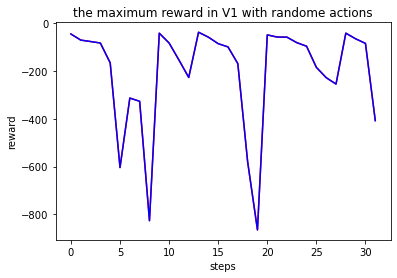

In [87]:

feed_for_max_reward_original= ['Initial Feed', 'B1T', 'B2B', 'B2T', 'B3B', 'Initial Feed', 'B1B', 'B1T', 'B2B', 'B4B', 'Initial Feed', 'B1T', 'B1B', 'B3T', 'B4T', 'Initial Feed', 'B1B', 'B1T', 'B3B', 'B4B', 'Initial Feed', 'B1B', 'B1T', 'B3B', 'B4B', 'Initial Feed', 'B1T', 'B2B', 'B2T', 'B1B', 'Initial Feed', 'B1T', 'B2T', 'B3B', 'B4T', 'Initial Feed', 'B1T', 'B2T', 'B3B', 'B2B', 'Initial Feed', 'B1T', 'B2B', 'B1B', 'B4T', 'Initial Feed', 'B1T', 'B2T', 'B3B', 'B1B', 'Initial Feed', 'B1T', 'B2B', 'B3B', 'B2T', 'Initial Feed', 'B1T', 'B2T', 'B2B', 'B3T', 'Initial Feed', 'B1T', 'B1B', 'B3B', 'B2B', 'Initial Feed', 'B1T', 'B2T', 'B1B', 'B4B', 'Initial Feed', 'B1T', 'B2T', 'B3B', 'B4T', 'Initial Feed', 'B1B', 'B2T', 'B3B', 'B4T', 'Initial Feed', 'B1B', 'B2B', 'B1T', 'B4B', 'Initial Feed', 'B1T', 'B2B', 'B3T', 'B4T', 'Initial Feed', 'B1T', 'B2B', 'B3B', 'B1B', 'Initial Feed', 'B1T', 'B1B', 'B3T', 'B2B', 'Initial Feed', 'B1T', 'B2B', 'B3B', 'B2T', 'Initial Feed', 'B1B', 'B2T', 'B1T', 'B4T', 'Initial Feed', 'B1T', 'B2T', 'B3B', 'B1B', 'Initial Feed', 'B1B', 'B1T', 'B2B', 'B4T', 'Initial Feed', 'B1B', 'B1T', 'B3B', 'B4T', 'Initial Feed', 'B1T', 'B2B', 'B3B', 'B3T', 'Initial Feed', 'B1B', 'B2T', 'B3T', 'B4B', 'Initial Feed', 'B1T', 'B2T', 'B3T', 'B4B', 'Initial Feed', 'B1T', 'B1B', 'B2B', 'B4B', 'Initial Feed', 'B1T', 'B2T', 'B2B', 'B4B', 'Initial Feed', 'B1T', 'B2B', 'B2T', 'B3T', 'Initial Feed', 'B1T', 'B2T', 'B3B', 'B3T']
lightkey_for_max_reward_original= ['1-BUT-01', 'N-BUT-01', '1-BUT-01', 'N-BUT-01', 'PROPY-01', 'PROPA-01', 'N-BUT-01', '1-BUT-01', 'N-BUT-01', 'PROPA-01', 'ETHAN-01', 'PROPA-01', 'N-BUT-01', 'PROPA-01', 'PROPA-01', 'PROPA-01', 'N-BUT-01', 'PROPA-01', 'N-BUT-01', 'N-BUT-01', 'ETHAN-01', 'PROPY-01', 'PROPA-01', 'ETHAN-01', 'PROPY-01', 'PROPY-01', 'ETHAN-01', 'PROPY-01', '1-BUT-01', '1-BUT-01', 'PROPA-01', 'N-BUT-01', 'PROPA-01', 'PROPY-01', 'N-BUT-01', 'PROPA-01', 'PROPY-01', 'ETHAN-01', 'ETHAN-01', 'PROPA-01', 'PROPA-01', 'N-BUT-01', 'PROPA-01', 'PROPA-01', '1-BUT-01', 'ETHAN-01', 'PROPA-01', 'ETHAN-01', 'ETHAN-01', '1-BUT-01', 'PROPA-01', 'ETHAN-01', 'PROPA-01', 'N-BUT-01', 'N-BUT-01', 'PROPA-01', 'N-BUT-01', 'PROPA-01', 'PROPA-01', 'ETHAN-01', 'PROPY-01', 'ETHAN-01', 'PROPY-01', 'PROPY-01', '1-BUT-01', 'PROPY-01', 'ETHAN-01', 'PROPA-01', 'N-BUT-01', '1-BUT-01', 'N-BUT-01', '1-BUT-01', 'ETHAN-01', 'PROPY-01', 'ETHAN-01', 'PROPA-01', 'PROPA-01', '1-BUT-01', 'N-BUT-01', 'PROPA-01', 'ETHAN-01', 'PROPA-01', 'N-BUT-01', 'ETHAN-01', 'PROPY-01', 'ETHAN-01', 'PROPA-01', '1-BUT-01', 'PROPA-01', 'N-BUT-01', 'PROPA-01', 'PROPA-01', 'PROPA-01', 'N-BUT-01', 'N-BUT-01', '1-BUT-01', 'ETHAN-01', 'N-BUT-01', 'PROPA-01', 'PROPY-01', 'PROPY-01', 'N-BUT-01', 'PROPY-01', 'PROPY-01', 'ETHAN-01', 'N-BUT-01', 'N-BUT-01', 'N-BUT-01', 'PROPA-01', 'PROPY-01', 'PROPA-01', 'PROPA-01', 'PROPA-01', '1-BUT-01', 'N-BUT-01', 'PROPA-01', 'PROPY-01', 'PROPA-01', 'PROPA-01', 'PROPY-01', 'PROPA-01', 'PROPA-01', '1-BUT-01', 'PROPA-01', '1-BUT-01', 'PROPY-01', '1-BUT-01', 'PROPY-01', 'PROPA-01', 'PROPA-01', 'ETHAN-01', 'N-BUT-01', 'ETHAN-01', 'N-BUT-01', '1-BUT-01', 'PROPA-01', 'PROPA-01', 'ETHAN-01', '1-BUT-01', 'ETHAN-01', '1-BUT-01', 'PROPA-01', 'N-BUT-01', 'N-BUT-01', 'PROPA-01', 'N-BUT-01', '1-BUT-01', 'ETHAN-01', 'N-BUT-01', 'PROPY-01', 'N-BUT-01', 'PROPA-01', 'N-BUT-01', 'ETHAN-01', 'PROPA-01', 'PROPA-01', 'ETHAN-01', 'PROPY-01', '1-BUT-01', 'ETHAN-01']


lightkeylistaction = []
feedlistaction = []
difference = []
for i in range(0,len(maxrewardwhichhasbeenfoundV1)):
    difference.append((maxrewardwhichhasbeenfoundV1[i]-maxrewardwhichhasbeenfoundV2[i])**2)
print(f'the square average difference between the two Stream value versions is: {sum(difference)/len(difference)} ')
indexreward = maxrewardwhichhasbeenfoundV1.index(max(maxrewardwhichhasbeenfoundV1))
for i in range(0,5,1):
    feedlistaction.append(feed_for_max_reward_original[(indexreward*5+i)])
    lightkeylistaction.append(lightkey_for_max_reward_original[(indexreward*5 +i)])
print(f'\n the reward for the following action sequence was: {maxrewardwhichhasbeenfoundV1[indexreward]}')
print(lightkeylistaction)
print(feedlistaction)
x = np.arange(0, len(maxrewardwhichhasbeenfoundV1), 1)
plt.plot(x, maxrewardwhichhasbeenfoundV1, 'red')
plt.plot(x, maxrewardwhichhasbeenfoundV2, 'blue')
plt.ylabel("reward")
plt.xlabel("steps")
plt.title('the maximum reward in V1 with randome actions')
plt.show()

# This code takes the max rewards which were found from the best simulations and extracts the actions. 

In [55]:

q = [-46.333285993461146, -71.73157866904748, -77.73822694813605, -83.95066056071373, -166.79254137633285, -307.50118821544834, -313.8478503691101, -327.4331760468841, -826.0966513208647, -42.97795394309483, -83.91968848372144, -154.7199482936461, -227.8319264501214, -38.94774942448791, -59.418380156262856, -86.66806393046784, -100.22234335884512, -170.0495987324897, -580.3143666041694, -864.6530243471057, -50.06471238717572, -59.03874613076937, -59.35917420882296, -82.2894675550954, -97.3710712117489, -185.65448583584666, -228.60713717747254, -255.3632227309166, -42.79940444831174, -66.39262591771715, -311.1913947879428, -408.099979746019]
qq = [-46.334117372433816, -71.73376726155473, -77.73939026683342, -83.95178167193998, -166.7936908961861, -307.50252014384307, -313.8480427970136, -327.43438562799673, -826.0983515531202, -42.979001054412706, -83.92101414645153, -154.72014072614834, -227.83297945707204, -38.94847395981446, -59.41846301092828, -86.66983618582665, -100.2232325574851, -170.05128604805256, -580.3155343955129, -864.6542867497205, -50.065750696621286, -59.03993665450352, -59.35926933976362, -82.29067675037165, -97.37176117093944, -185.65554495369264, -228.60744694828037, -255.36392234704982, -42.80096566432073, -66.39440872548208, -311.19295930926586, -408.10100965431286]
maxrewardwhichhasbeenfoundV1 = q
maxrewardwhichhasbeenfoundV2 = qq
lightkeylistaction = []
feedlistaction = []
difference = []
for i in range(0,len(q)):
    difference.append((q[i]-qq[i])**2)
print(f'the square average difference between the two Stream value versions is: {sum(difference)/len(difference)} ')
indexreward = maxrewardwhichhasbeenfoundV1.index(max(maxrewardwhichhasbeenfoundV1))
for i in range(0,5,1):
    feedlistaction.append(feed_for_max_reward[(indexreward*5+i)])
    lightkeylistaction.append(lightkey_for_max_reward[(indexreward*5 +i)])
print(f'\n the reward for the following action sequence was: {maxrewardwhichhasbeenfoundV1[indexreward]}')
print(lightkeylistaction)
print(feedlistaction)


the square average difference between the two Stream value versions is: 1.4099756012508566e-06 

 the reward for the following action sequence was: -38.94774942448791
['PROPY-01', 'ETHAN-01', 'PROPA-01', 'N-BUT-01', '1-BUT-01']
['Initial Feed', 'B1T', 'B2T', 'B1B', 'B4B']


NameError: name 'hist' is not defined

In [38]:
print(f'the square average difference between the two Stream value versions is: {sum(difference)/len(difference)} ')




counter = 0
functionlist = [stable_env.MonetaryGainV1remembered, stable_env.MonetaryGainV2remembered, stable_env.Punishmentremembered, stable_env.MonetaryLossremembered, stable_env.MoneyForBankersremembered, stable_env.OperationalcostsForCurrentSequenceremembered]
titelList = ['Monetary Gain Version 1' , 'Monetary Gain Version 2', 'Punishment','Monetary Loss','Fixed Capital costs','Operational costs']
for i in functionlist:
    plt.plot(i)
    plt.title(f'{titelList[counter]}')
    plt.xlabel("steps")
    plt.ylabel("money $/h")
    plt.plot((np.ones(len(i))*sum(i)/len(i)), color = 'red')
    plt.plot((statistics.median(i)*np.ones(len(i))) ,color = 'green')
    plt.show()
    print(f'the average value is: {sum(i)/len(i)}')
    print(f'the median value is: {statistics.median(i)}')
    print(f'the minimum value is: {min(i)}')
    print(f'the maximum value is: {max(i)}')
    counter = counter +1    


the square average difference between the two Stream value versions is: 8.551885149271755e-07 


AttributeError: 'StableEnv' object has no attribute 'MonetaryGainV1remembered'

In [41]:
print(stable_env.MonetaryGainV1)
print(stable_env.MonetaryGainV2)
print(stable_env.Punishment)
print(stable_env.MonetaryLoss) 
print(stable_env.MoneyForBankers)
print(stable_env.OperationalcostsForCurrentSequence)

0.0011136293575086452
0.0
300.0
3.7999999999999995e-05
8.91090272937165
125.21572362712018
